In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.integrate import odeint
from scipy.integrate import quad
import seaborn as sns
import matplotlib.colors as colors
from matplotlib import rcParams
from matplotlib.colors import LogNorm
from scipy.interpolate import InterpolatedUnivariateSpline
import ji_ji_prime_method2
import mass_function
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})


π = np.pi
G = 4.4959e-15            #in units of M☉^-1 pc^3 yr^-2
c = 0.3068                #in units of pc yr^-1
ρ_eq = 3.1812e3           #in units of M☉ pc^-3 with ρ_eq=2.15368e-16 kg m^-3
t = 13.78e9               #in units of yrs corresponding to t_0=13.78Gyr
yr = 3.154e7              # in units of seconds
pc = 3.0857e16            # in meters
yr = 3.154e7              # in units of seconds
t_eq = 1.59246e12/yr      # in units of seconds
ρ_m  = 4e19                #ρ_m=4e19 M☉ Gpc^-3
t_m = 13.78e9             #in units of yr 
σ_eq = 0.005



def interpolation(x, y, variable):
    g =  InterpolatedUnivariateSpline(x, y, ext = 2, k= 1) # j_i = g(t_m)
    return g(variable)
   
    

def merger_method_2(m_1, m_2, Δ_1, Δ_2, t_m, DM_halos_presence):
    
    if m_1 < m_min:
        return 0
    
    elif m_2 < m_min:
        return 0
    
    else: #1
        
        def f_(m):
            return f*P(m)

        def f_b(m_1,m_2):
            return  f_(m_1)+f_(m_2)

        def λ(m_1, m_2, Δ_1, Δ_2, X): # λ_0
            return  X/(f_b(m_1,m_2)*np.sqrt(Δ_1*Δ_2))

        def PDF(m):
            return (P(m)/m)


        I = quad(PDF, m_min, m_max)             # Taking limits of the PBH mass from m_min M☉ to m_max M☉ instead of 
                                             # 0 to infinity.

        n_T = f * ρ_eq * I[0]                #n_T=f*ρ_eq∫(P(m)/m)*dm 

        def x̄(m_1,m_2,Δ_1,Δ_2):
            return (((3 * (m_1 + m_2))/(8 * π * ρ_eq * f_b(m_1,m_2) * np.sqrt(Δ_1 * Δ_2)))**(1/3))
    
        X = np.geomspace(X_min, X_max, 100000) 
        
        
        if DM_halos_presence == 'False':
        
        # Merger rate of  PBH binaries without halos for PBHs mass range of 5 M☉-100 M☉ .
        
        
            k = 22.3819
            A = ((ρ_eq**(4/3))*(G**3)*(k**7))/(c**5)

            def B_nohalo(m_1,m_2,Δ_1,Δ_2):
                return (A**(1/7)) * ((m_1 * m_2 * t_m)**(1/7)) * ((m_1 + m_2)**(-1/21)) * ((f_b(m_1,m_2))**(37/21)) * ((f**2 + 1.1994*(σ_eq**2))**(-1/2)) * ((Δ_1*Δ_2)**(37/42))

            
        
            def γ_X_nohalo(m_1,m_2,Δ_1,Δ_2, X):        #eq.(12) in the notes.
                return (((1 + 0.1709 * λ(m_1, m_2, Δ_1, Δ_2, X))**(-1/14))/(1 + 0.0443 * λ(m_1, m_2, Δ_1, Δ_2, X))) *  B_nohalo(m_1,m_2,Δ_1,Δ_2) * (X**(-37/21))
            
       
        
            def integrand_nohalo(m_1,m_2,Δ_1,Δ_2, X):
                return  np.exp(-((4*π)/3)  * (x̄(m_1,m_2,Δ_1,Δ_2)**3) * n_T * X) * ((γ_X_nohalo(m_1,m_2,Δ_1,Δ_2, X)**2) / ((1 + (γ_X_nohalo(m_1,m_2,Δ_1,Δ_2, X)**2))**(3/2)))
        
        
            return (1/(14 * t_m)) *  ρ_m *  ((f**2)/(f_b(m_1,m_2)*np.sqrt(Δ_1*Δ_2))) *  (m_1 + m_2) * np.minimum((P(m_1)*Δ_1)/m_1, (P(m_2)*Δ_2)/m_2) * ((P(m_1)*Δ_1)/m_1 + (P(m_2)*Δ_2)/m_2)  * (np.trapz(integrand_nohalo(m_1,m_2,Δ_1,Δ_2, X),X)) 
    
       
        
        else: #3
            beta = 0.75
            gamma  =  0.65
            delta = -0.89   
            m1_ref = 1      # in units of solar mass.
            m2_ref = 1e-3   # in units of solar mass.

            m = file['arr_0']
            b = file['arr_1']
            a_i_ref = file['arr_2']  # in units of pc
            ji_ref_list = file['arr_3']
            tm_ref_list = file['arr_4']

            def a_initial(m_1, m_2, Δ_1, Δ_2, X):  # for x = x_bar 
                return (0.0977*λ(m_1,m_2,Δ_1,Δ_2, X) + 0.0057*(λ(m_1,m_2,Δ_1,Δ_2, X)**2)) * x̄(m_1,m_2,Δ_1,Δ_2) * (X**(1/3))


            def C(m_1,m_2,Δ_1,Δ_2, X):
                return ((a_initial(m_1,m_2,Δ_1,Δ_2, X)/a_i_ref)**(beta)) * ((m_1/ m1_ref)**(gamma)) * ((m_2/m2_ref)**(delta))
              
            
            
            C_list = (C(m_1,m_2,Δ_1,Δ_2, X)).tolist()
            j_initial_list = np.zeros(len(C_list))
            j_initial_prime_list  = np.zeros(len(C_list))
            
            
            for i, C in enumerate(C_list):
                variable = t_m/C
                
                if variable <= tm_ref_list[0]:
                    
                    j_i = ji_ji_prime_method2.ji_into_C_fitting_function(m, b, t_m) / (C**(1/m))   # t_m = (j_i**m) * (10**b)
                    j_i_prime = ji_ji_prime_method2.ji_into_C_prime_fitting_function(m, b, t_m) / (C**(1/m)) 
                  
                elif tm_ref_list[0] < variable < tm_ref_list[-1]:
                    x = tm_ref_list
                    y = ji_ref_list
                    j_i = ji_ji_prime_method2.ji_interpolation(x, y, variable)
                    j_i_prime = ji_ji_prime_method2.ji_prime_into_C_interpolation(x, y, variable) / C
                        
                else: 
                    j_i =   1    #Used as 1 instead of zero to avoid the divide by zero error in the integrand.                          
                    j_i_prime =   0                      
                
                
                j_initial_list[i]       =  j_i
                j_initial_prime_list[i] =  j_i_prime
                
            
            j_initial = np.array(j_initial_list) 
            j_initial_prime = np.array(j_initial_prime_list)
            
            
            def s(m_1, m_2, Δ_1, Δ_2, X): # S_dec of the binary decouple.
                return ((0.03095*λ(m_1, m_2, Δ_1, Δ_2, X)+ 0.3425)*λ(m_1, m_2, Δ_1, Δ_2, X))

            def t(m_1, m_2, Δ_1, Δ_2, X):  #t_dec of the binary decouple.
                return ((np.sqrt(3/(8*π*G*ρ_eq)))*(((2/3)*(s(m_1, m_2, Δ_1, Δ_2, X)-2)*np.sqrt(s(m_1, m_2, Δ_1, Δ_2, X)+1))+(4/3)))


            def ρ_bar(m):
                return ((ρ_eq/2)*(t_eq**(3/2))*((2*G*m)**(3/4))) 

            def M_halo(m, m_1, m_2, Δ_1, Δ_2, X):
                return (((16*π)/3)*ρ_bar(m)*((2 * G * m *(t(m_1, m_2, Δ_1, Δ_2, X)**2))**(1/4)))
 
            def M(m, m_1, m_2, Δ_1, Δ_2, X):
                return (m + M_halo(m, m_1, m_2, Δ_1, Δ_2, X))
   
            def M_binary_initial(m_1, m_2, Δ_1, Δ_2, X):
                return (m_1 + m_2 + M_halo(m_1, m_1, m_2, Δ_1, Δ_2, X) + M_halo(m_2, m_1, m_2, Δ_1, Δ_2, X))

                # Merger rate of  PBH binaries without halos for PBHs mass range of m_min M☉ - m_max M☉.
            def D_halo(m_1, m_2, Δ_1, Δ_2, X):
                return ( 1 + 0.0857 * λ(m_1, m_2, Δ_1, Δ_2, X))/ np.sqrt(1 + 0.0583 * λ(m_1, m_2, Δ_1, Δ_2, X))

            
            def j_X_halo(m_1, m_2, Δ_1, Δ_2, X):
                return 0.4087 * np.sqrt(f**2 + 0.2998 * (σ_eq**2)) * D_halo(m_1, m_2, Δ_1, Δ_2, X) * np.sqrt((m_1 + m_2)/ M_binary_initial(m_1, m_2, Δ_1, Δ_2, X)) * (X/(f_b(m_1,m_2) * np.sqrt(Δ_1*Δ_2)))

            
            def γ_X_halo(m_1,m_2,Δ_1,Δ_2, X):    
                return j_initial/ j_X_halo(m_1, m_2, Δ_1, Δ_2, X)

            
            
            def integrand_halo(m_1,m_2,Δ_1,Δ_2, X):
                return j_initial_prime * (1/j_initial) * ((γ_X_halo(m_1,m_2,Δ_1,Δ_2, X)**2)/ ((1 + (γ_X_halo(m_1,m_2,Δ_1,Δ_2, X)**2))**(3/2))) * np.exp(- X * ((4*π)/3) * (x̄(m_1,m_2,Δ_1,Δ_2)**3) * n_T)

            
            return  (ρ_m/2) * (((f**2)* (m_1 + m_2))/(f_b(m_1,m_2) * np.sqrt(Δ_1*Δ_2))) * np.minimum((P(m_1)*Δ_1)/m_1, (P(m_2)*Δ_2)/m_2) * ((P(m_1)*Δ_1)/m_1 + (P(m_2)*Δ_2)/m_2) *   (np.trapz(integrand_halo(m_1,m_2,Δ_1,Δ_2, X),X))       



In [2]:
bin_centres = np.geomspace(6, 91, 16)
bin_edges = np.sqrt(bin_centres[:-1]*bin_centres[1:])


ratio = bin_edges[1]/bin_edges[0] 
bin_edges = np.append(bin_edges[0]/ratio, bin_edges) 
bin_edges = np.append(bin_edges, bin_edges[-1]*ratio) 


deltas = np.diff(bin_edges)




Δ_1_list = deltas.tolist()
Δ_2_list = deltas.tolist()



m_1 = np.geomspace(6, 91, 16)
m_2 = np.geomspace(6, 91, 16)


m_1_list = m_1.tolist()
m_2_list = m_2.tolist()   



m_1_list = [np.ceil(m_1) for m_1 in m_1_list]
m_2_list = [np.ceil(m_2) for m_2 in m_2_list]
    




Δ_1_list = list(map(lambda x: float(format(x, '.8f')),  Δ_1_list))   
Δ_2_list = list(map(lambda x: float(format(x, '.8f')),  Δ_2_list)) 
    

print('\v')
print("m_1 =", m_1_list, "M☉")
print('\v')
print("Δ_1 =", Δ_1_list)



m_min = 5     #in units of M☉
m_max = 100   #in units of M☉

X_min = 1e-5
X_max = 1e5


m_1 = [6.0, 8.0, 9.0, 11.0, 13.0, 15.0, 18.0, 22.0, 26.0, 31.0, 37.0, 45.0, 53.0, 64.0, 76.0, 91.0] M☉

Δ_1 = [1.08912979, 1.30558649, 1.56506239, 1.87610726, 2.24897006, 2.69593666, 3.23173464, 3.87401861, 4.64395189, 5.56690386, 6.67328589, 7.99955337, 9.58940696, 11.49523249, 13.77982711, 16.51846845]


In [3]:
# Calculation of the 2D merger rate for Log-Normal PBH mass Distribution. 
#The resolution of the PBHs masses m_1 is Δ_1 and of m_2 is Δ_2.


DM_halos_presence = 'False'
Merger_Lognormal_nohalo = np.zeros((16, 16))
merger_sum = 0


for i, (m_1, Δ_1)  in enumerate(zip(m_1_list, Δ_1_list)):
    
    for j, (m_2, Δ_2) in enumerate(zip(m_2_list, Δ_2_list)):
        
        f_pbh = 2.20e-3
        f = 0.85*f_pbh
   
        def P(m):                  #Log-Normal PBH mass Distribution
            σ = 0.6
            m_c = 15               #in units of M☉, for PBHs mass range of m_min = 5 M☉ - m_max = 100 M☉ .
            return  (1/(σ * m * np.sqrt(2*π))) * np.exp(-(((np.log(m/m_c))**2)/(2*(σ**2))))


        if i==j:
            Merger_Lognormal_nohalo[i, j] = 0.5 * merger_method_2(m_1, m_2, Δ_1 , Δ_2, t_m, DM_halos_presence) 
            
        else:
            Merger_Lognormal_nohalo[i, j] = merger_method_2(m_1, m_2, Δ_1 , Δ_2, t_m, DM_halos_presence)
        
        
        if m_1 < m_2:
                
                merger_sum +=  0
        
        else:
                merger_sum +=  Merger_Lognormal_nohalo[i,j]
            


print("Merger =", merger_sum, 'Gpc⁻3 yr⁻1')
np.save("Merger_Lognormal_nohalo", Merger_Lognormal_nohalo)

Merger = 41.269462359468406 Gpc⁻3 yr⁻1


In [4]:
file = np.load('tm_ofj0_Lgnmlhalo_1.npz')
m = file['arr_0']
b = file['arr_1']
a_i_ref =  file['arr_2']
ji_ref_list = file['arr_3']
tm_ref_list = file['arr_4']




# Calculation of the 2D merger rate for Log-Normal PBH mass Distribution. 
#The resolution of the PBHs masses m_1 is Δ_1 and of m_2 is Δ_2.


DM_halos_presence = 'True'
Merger_Lognormal_halo_method_2 = np.zeros((16, 16))
merger_sum = 0


for i, (m_1, Δ_1)  in enumerate(zip(m_1_list, Δ_1_list)):
    
    for j, (m_2, Δ_2) in enumerate(zip(m_2_list, Δ_2_list)):
        
        f_pbh = 2.20e-3
        f = 0.85*f_pbh
   
        def P(m):                  #Log-Normal PBH mass Distribution
            σ = 0.6
            m_c = 15               #in units of M☉, for PBHs mass range of m_min = 5 M☉ - m_max = 100 M☉ .
            return  (1/(σ * m * np.sqrt(2*π))) * np.exp(-(((np.log(m/m_c))**2)/(2*(σ**2))))


        if i==j:
            Merger_Lognormal_halo_method_2[i, j] = 0.5 * merger_method_2(m_1, m_2, Δ_1 , Δ_2, t_m, DM_halos_presence) 
            
        else:
            Merger_Lognormal_halo_method_2[i, j] = merger_method_2(m_1, m_2, Δ_1 , Δ_2, t_m, DM_halos_presence)
        
        if m_1 < m_2:
                
                merger_sum +=  0
        
        else:
                merger_sum +=  Merger_Lognormal_halo_method_2[i,j]
            

print("Merger =", merger_sum, 'Gpc⁻3 yr⁻1')
np.save("Merger_Lognormal_halo_method_2", Merger_Lognormal_halo_method_2)

Merger = 5.994336863913257e-11 Gpc⁻3 yr⁻1


In [ ]:
# Merger rates for Power Law of PBH masses from m_min = 1e-2 M☉ - m_max = 100 M☉. 

In [5]:
bin_centres = np.geomspace(2e-2, 78, 16)
bin_edges = np.sqrt(bin_centres[:-1]*bin_centres[1:])


ratio = bin_edges[1]/bin_edges[0] 
bin_edges = np.append(bin_edges[0]/ratio, bin_edges) 
bin_edges = np.append(bin_edges, bin_edges[-1]*ratio) 


deltas = np.diff(bin_edges)




Δ_1_list = deltas.tolist()
Δ_2_list = deltas.tolist()



m_1 = np.geomspace(2e-2, 78, 16)
m_2 = np.geomspace(2e-2, 78, 16)


m_1_list = m_1.tolist()
m_2_list = m_2.tolist()   



m_1_list = list(map(lambda x: float(format(x, '.2f')), m_1_list))   
m_2_list = list(map(lambda x: float(format(x, '.2f')), m_2_list)) 
 
 
    
    
m_1_list = [0.02, 0.03, 0.06, 0.1, 0.2, 0.3, 0.6, 1, 2, 3, 5, 9, 15, 26, 45, 78]  
m_2_list = [0.02, 0.03, 0.06, 0.1, 0.2, 0.3, 0.6, 1, 2, 3, 5, 9, 15, 26, 45, 78] 


Δ_1_list = list(map(lambda x: float(format(x, '.8f')),  Δ_1_list))   
Δ_2_list = list(map(lambda x: float(format(x, '.8f')),  Δ_2_list)) 
    

print('\v')
print("m_1 =", m_1_list, "M☉")
print('\v')
print("Δ_1 =", Δ_1_list)


m_min = 1e-2  #in units of M☉
m_max = 100   #in units of M☉

X_min = 1e-5
X_max = 1e5


m_1 = [0.02, 0.03, 0.06, 0.1, 0.2, 0.3, 0.6, 1, 2, 3, 5, 9, 15, 26, 45, 78] M☉

Δ_1 = [0.0111651, 0.01937612, 0.03362569, 0.05835466, 0.10126977, 0.17574547, 0.30499199, 0.52928885, 0.91853783, 1.59404786, 2.76634068, 4.80075972, 8.33132886, 14.45834503, 25.09128432, 43.54388745]


In [6]:
# Calculation of the 2D merger rate for Powerlaw PBH mass distribution. 
#The resolution of the PBHs masses m_1 is Δ_1 and of m_2 is Δ_2.

DM_halos_presence = 'False'
Merger_PWR_nohalo = np.zeros((16, 16))
merger_sum = 0

for i, (m_1, Δ_1)  in enumerate(zip(m_1_list, Δ_1_list)):
    
    for j, (m_2, Δ_2) in enumerate(zip(m_2_list, Δ_2_list)):
        
        f_pbh = 1e-3      #choosen as an arbitrary value for now
        f = 0.85*f_pbh
   
        def P(m):     #Powerlaw PBH mass distribution
            α = 1.6
            M = 1e-2      #in units of M☉, for PBHs mass range of m_min = 1e-2 M☉ - m_max = 100 M☉ .
            return ((α-1)/M) * ((m/M)**(-α))


        if i==j:
            Merger_PWR_nohalo[i, j] = 0.5 * merger_method_2(m_1, m_2, Δ_1 , Δ_2, t_m, DM_halos_presence) 
            
        else:
            Merger_PWR_nohalo[i, j] = merger_method_2(m_1, m_2, Δ_1 , Δ_2, t_m, DM_halos_presence)
        
        
        if m_1 < m_2:
            
            merger_sum += 0
        
        else:
            merger_sum += Merger_PWR_nohalo[i,j]


        
print("Merger =", merger_sum, 'Gpc⁻3 yr⁻1')
np.save("Merger_PWR_nohalo", Merger_PWR_nohalo)

Merger = 978.0404367122084 Gpc⁻3 yr⁻1


In [7]:
file = np.load('tm_ofj0_PWRhalo_2.npz')
m = file['arr_0']
b = file['arr_1']
a_i_ref =  file['arr_2']
ji_ref_list = file['arr_3']
tm_ref_list = file['arr_4']



# Calculation of the 2D merger rate for Powerlaw PBH mass distribution. 
#The resolution of the PBHs masses m_1 is Δ_1 and of m_2 is Δ_2.

DM_halos_presence = 'True'
Merger_PWR_halo_method_2 = np.zeros((16, 16))
merger_sum = 0


for i, (m_1, Δ_1)  in enumerate(zip(m_1_list, Δ_1_list)):
    
    for j, (m_2, Δ_2) in enumerate(zip(m_2_list, Δ_2_list)):
        
        f_pbh = 1e-3      #choosen as an arbitrary value for now
        f = 0.85*f_pbh
   
        def P(m):     #Powerlaw PBH mass distribution
            α = 1.6
            M = 1e-2     #in units of M☉, for PBHs mass range of m_min = 1e-2 M☉ - m_max = 100 M☉ .
            return ((α-1)/M) * ((m/M)**(-α))


        if i==j:
            Merger_PWR_halo_method_2[i, j] = 0.5 * merger_method_2(m_1, m_2, Δ_1 , Δ_2, t_m, DM_halos_presence) 
            
        else:
            Merger_PWR_halo_method_2[i, j] = merger_method_2(m_1, m_2, Δ_1 , Δ_2, t_m, DM_halos_presence)
        
        if m_1 < m_2:
            
            merger_sum += 0
        
        else:
            merger_sum += Merger_PWR_halo_method_2[i,j]


print("Merger =", merger_sum, 'Gpc⁻3 yr⁻1')
np.save("Merger_PWR_halo_method_2", Merger_PWR_halo_method_2)

Merger = 2834917.0328425295 Gpc⁻3 yr⁻1


In [14]:
# Merger rates  for the range of PBH masses from m_min = 1e-4 M☉ - m_max = 100 M☉ using
# mass function of the paper https://arxiv.org/abs/2207.07576 . 

In [8]:
bin_centres = np.geomspace(2e-4, 69, 16)
bin_edges = np.sqrt(bin_centres[:-1]*bin_centres[1:])


ratio = bin_edges[1]/bin_edges[0] 
bin_edges = np.append(bin_edges[0]/ratio, bin_edges) 
bin_edges = np.append(bin_edges, bin_edges[-1]*ratio) 


deltas = np.diff(bin_edges)




Δ_1_list = deltas.tolist()
Δ_2_list = deltas.tolist()



m_1 = np.geomspace(2e-4, 69, 16)
m_2 = np.geomspace(2e-4, 69, 16)


m_1_list = m_1.tolist()
m_2_list = m_2.tolist()   



m_1_list = list(map(lambda x: float(format(x, '.4f')), m_1_list))   
m_2_list = list(map(lambda x: float(format(x, '.4f')), m_2_list)) 



m_1_list = [0.0002, 0.0005, 0.001, 0.003, 0.006, 0.01, 0.03, 0.08, 0.2, 0.4, 1, 2, 5, 
             12, 29, 69] 


m_2_list = [0.0002, 0.0005, 0.001, 0.003, 0.006, 0.01, 0.03, 0.08, 0.2, 0.4, 1, 2, 5,  
             12, 29, 69]



Δ_1_list = list(map(lambda x: float(format(x, '.8f')),  Δ_1_list))   
Δ_2_list = list(map(lambda x: float(format(x, '.8f')),  Δ_2_list)) 
    

print('\v')
print("m_1 =", m_1_list, "M☉")
print('\v')
print("Δ_1 =", Δ_1_list)

m_min = 1e-4
m_max = 100

X_min = 1e-5
X_max = 1e5


m_1 = [0.0002, 0.0005, 0.001, 0.003, 0.006, 0.01, 0.03, 0.08, 0.2, 0.4, 1, 2, 5, 12, 29, 69] M☉

Δ_1 = [0.00017518, 0.0004099, 0.00095911, 0.00224417, 0.00525102, 0.0122866, 0.0287488, 0.06726787, 0.15739669, 0.36828457, 0.86173051, 2.01631977, 4.71788496, 11.03914116, 25.82992984, 60.43815056]


In [9]:
# Calculation of the 2D merger rate for mass function of the paper https://arxiv.org/abs/2207.07576 . 
#The resolution of the PBHs masses m_1 is Δ_1 and of m_2 is Δ_2.

DM_halos_presence = 'False'
Merger_new_PDF_nohalo = np.zeros((16, 16))


merger_sum = 0
for i, (m_1, Δ_1)  in enumerate(zip(m_1_list, Δ_1_list)):
    
    for j, (m_2, Δ_2) in enumerate(zip(m_2_list, Δ_2_list)):
        
        f_pbh = mass_function.f_PBH      
        f = 0.85*f_pbh
   
        def P(m):    #in units of M☉, for PBHs mass range of m_min = 1e-4 M☉ - m_max = 100 M☉ 
            return mass_function.new_PDF(m)


        if i==j:
            Merger_new_PDF_nohalo[i, j] = 0.5 * merger_method_2(m_1, m_2, Δ_1 , Δ_2, t_m, DM_halos_presence) 
            
        else:
            Merger_new_PDF_nohalo[i, j] = merger_method_2(m_1, m_2, Δ_1 , Δ_2, t_m, DM_halos_presence)
        
        
        if m_1 < m_2:
            
            merger_sum += 0
        
        else:
            merger_sum += Merger_new_PDF_nohalo[i,j]


        
print("Merger =", merger_sum, 'Gpc⁻3 yr⁻1')
np.save("Merger_new_PDF_nohalo", Merger_new_PDF_nohalo)

/tmp/ipykernel_41845/3058067822.py:63: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  I = quad(PDF, m_min, m_max)             # Taking limits of the PBH mass from m_min M☉ to m_max M☉ instead of


Merger = 347505.0071492132 Gpc⁻3 yr⁻1


In [10]:
# Calculation of the 2D merger rate for mass function of the paper https://arxiv.org/abs/2207.07576 . 
#The resolution of the PBHs masses m_1 is Δ_1 and of m_2 is Δ_2.


file = np.load('tmofj0_new_PDF.npz')
m = file['arr_0']
b = file['arr_1']
a_i_ref =  file['arr_2']
ji_ref_list = file['arr_3']
tm_ref_list = file['arr_4']



DM_halos_presence = 'True'
Merger_new_PDF_halo_method_2 = np.zeros((16, 16))


merger_sum = 0
for i, (m_1, Δ_1)  in enumerate(zip(m_1_list, Δ_1_list)):
    
    for j, (m_2, Δ_2) in enumerate(zip(m_2_list, Δ_2_list)):
        
        f_pbh = mass_function.f_PBH      
        f = 0.85*f_pbh
   
        def P(m):    #in units of M☉, for PBHs mass range of m_min = 1e-4 M☉ - m_max = 100 M☉ 
            return mass_function.new_PDF(m)


        if i==j:
            Merger_new_PDF_halo_method_2[i, j] = 0.5 * merger_method_2(m_1, m_2, Δ_1 , Δ_2, t_m, DM_halos_presence) 
            
        else:
            Merger_new_PDF_halo_method_2[i, j] = merger_method_2(m_1, m_2, Δ_1 , Δ_2, t_m, DM_halos_presence)
        
        
        if m_1 < m_2:
            
            merger_sum += 0
        
        else:
            merger_sum += Merger_new_PDF_halo_method_2[i,j]


        
print("Merger =", merger_sum, 'Gpc⁻3 yr⁻1')
np.save("Merger_new_PDF_halo_method_2", Merger_new_PDF_halo_method_2)

/tmp/ipykernel_41845/3058067822.py:63: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  I = quad(PDF, m_min, m_max)             # Taking limits of the PBH mass from m_min M☉ to m_max M☉ instead of


Merger = 2197606.4697805727 Gpc⁻3 yr⁻1


In [3]:
# Merger rate plots for Lognormal PDF in mass range (5 - 100) M_sun

In [30]:

bin_centres = np.geomspace(6, 91, 16)
bin_edges = np.sqrt(bin_centres[:-1]*bin_centres[1:])


ratio = bin_edges[1]/bin_edges[0] 
bin_edges = np.append(bin_edges[0]/ratio, bin_edges) 
bin_edges = np.append(bin_edges, bin_edges[-1]*ratio) 


deltas = np.diff(bin_edges)




Δ_1_list = deltas.tolist()
Δ_2_list = deltas.tolist()



m_1 = np.geomspace(6, 91, 16)
m_2 = np.geomspace(6, 91, 16)


m_1_list = m_1.tolist()
m_2_list = m_2.tolist()   



m_1_list = [np.ceil(m_1) for m_1 in m_1_list]
m_2_list = [np.ceil(m_2) for m_2 in m_2_list]
    
m_1_list = [('%f' % m_1).rstrip('0').rstrip('.') for m_1 in m_1_list]
m_2_list = [('%f' % m_2).rstrip('0').rstrip('.') for m_2 in m_2_list]
   




Δ_1_list = list(map(lambda x: float(format(x, '.8f')),  Δ_1_list))   
Δ_2_list = list(map(lambda x: float(format(x, '.8f')),  Δ_2_list)) 
    

print('\v')
print("m_1 =", m_1_list, "M☉")
print('\v')
print("Δ_1 =", Δ_1_list)



m_min = 5     #in units of M☉
m_max = 100   #in units of M☉

X_min = 1e-5
X_max = 1e5



m_1 = ['6', '8', '9', '11', '13', '15', '18', '22', '26', '31', '37', '45', '53', '64', '76', '91'] M☉

Δ_1 = [1.08912979, 1.30558649, 1.56506239, 1.87610726, 2.24897006, 2.69593666, 3.23173464, 3.87401861, 4.64395189, 5.56690386, 6.67328589, 7.99955337, 9.58940696, 11.49523249, 13.77982711, 16.51846845]


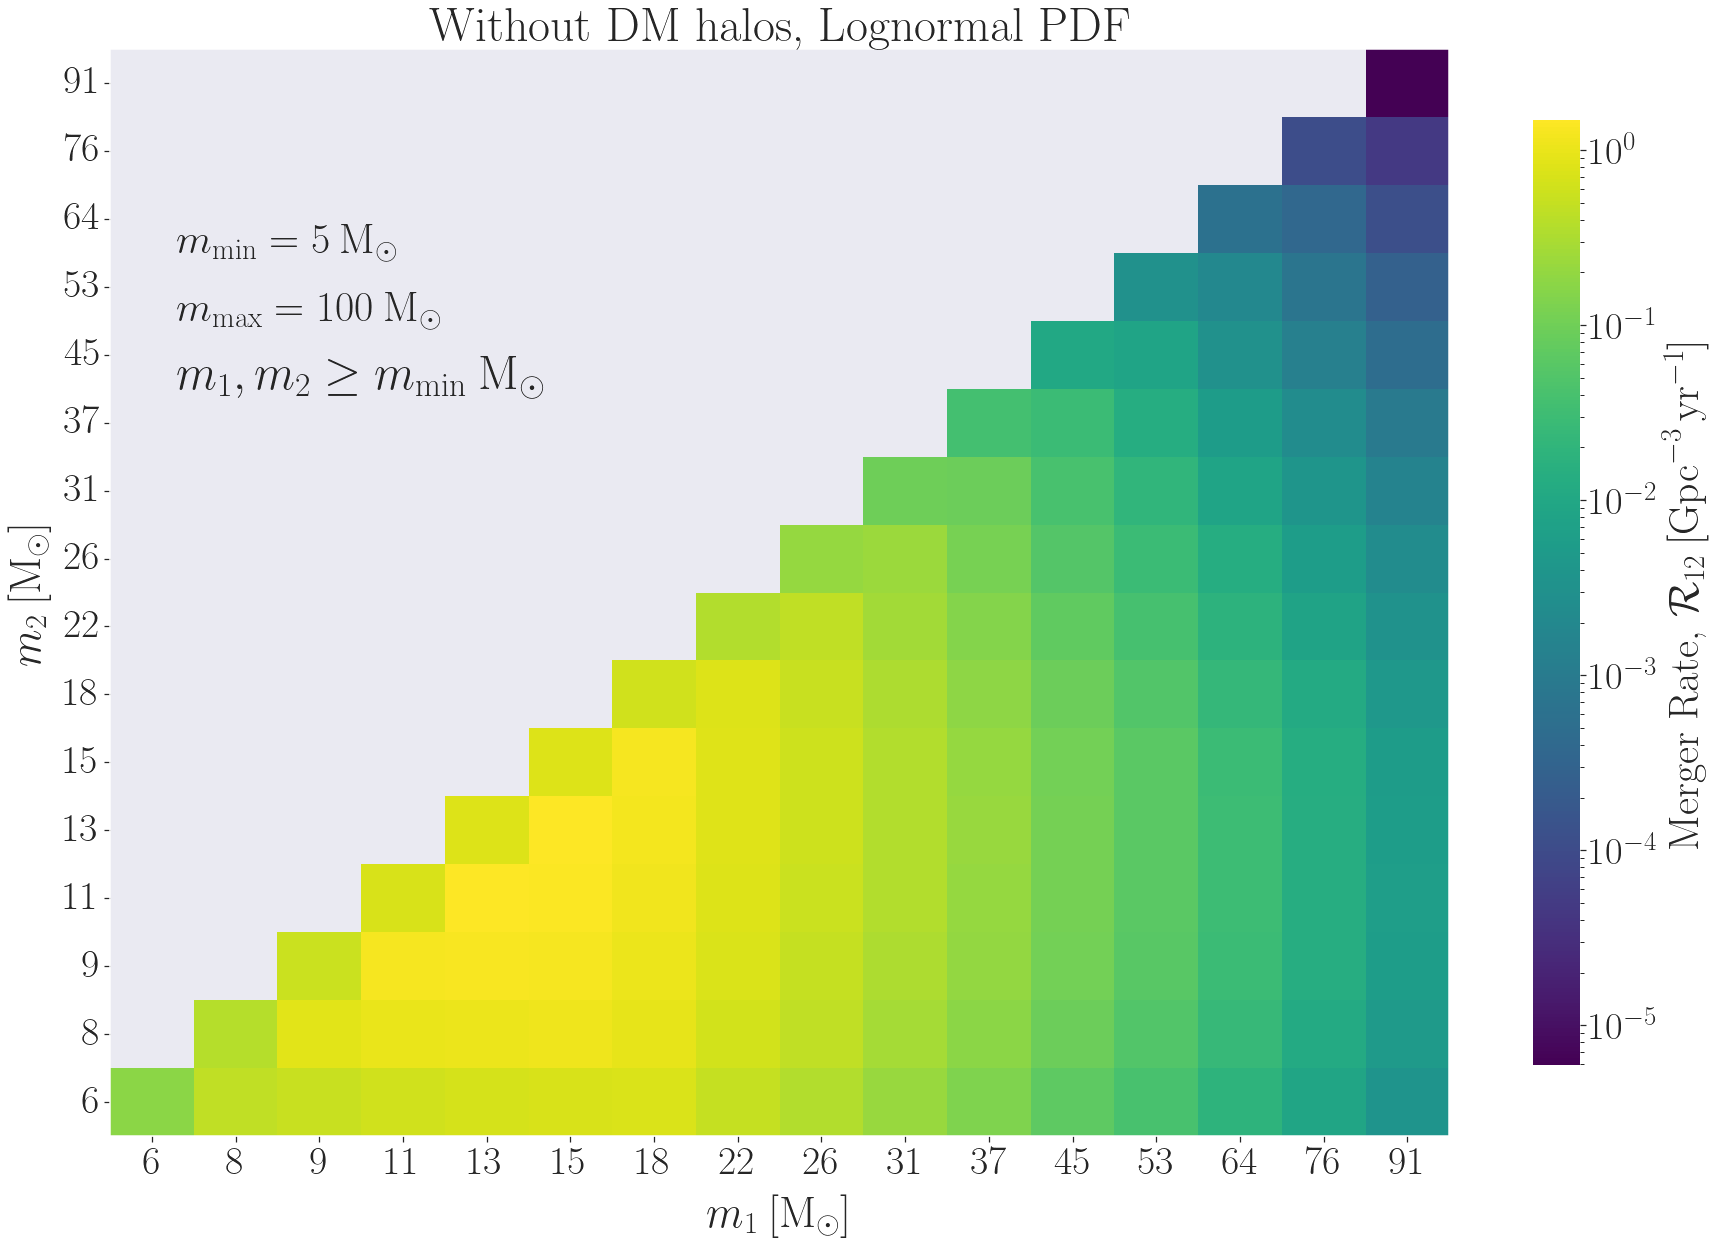

In [31]:
# Plot for Lognormal PDF in mass range (5 - 100 ) M_sun

Merger_Lognormal_nohalo = np.load('Merger_Lognormal_nohalo.npy')
Merger_Lognormal_halo_method_2 = np.load('Merger_Lognormal_halo_method_2.npy')


mask = np.tril(np.ones((16, 16)),k = -1)  #created an array of shape Merger_12 with all the elements in it being 0.
fig,ax = plt.subplots(figsize = (30, 20))  


sns.set(font_scale = 3.5)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'




vmin = np.min(Merger_Lognormal_nohalo)
vmax = np.max(Merger_Lognormal_nohalo)
norm = LogNorm(vmin, vmax)


ax = sns.heatmap(Merger_Lognormal_nohalo, mask = mask,  cmap = 'viridis', cbar = True, norm = norm,
                 cbar_kws = {"shrink": 0.87,'label': 'Merger Rate, $\mathcal{R}_{12} \: [\mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1}]$'})


ax.set_xticklabels(m_1_list, fontsize = 10)
ax.set_yticklabels(m_2_list, rotation = 360, fontsize = 10)
ax.tick_params(left = True, bottom = True)


ax.text(0.8, 13, "$m_\mathrm{{min}} = 5 \: \mathrm{M_{\odot}}$", size = 42)
ax.text(0.8, 12, "$m_\mathrm{{max}} = 100 \: \mathrm{M_{\odot}}$", size = 42)
ax.text(0.8, 11, "$m_{1}, m_{2} \geq m_\mathrm{min} \: \mathrm{M_{\odot}}$", size = 48)



# make frame visible
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1.5)


ax.invert_yaxis()
plt.xticks(fontsize = 40)
plt.yticks(fontsize = 40)
plt.xlabel('$m_{1}\: [\mathrm{M_{\odot}}]$', fontsize = 44, labelpad = 13)
plt.ylabel('$m_{2}\: [\mathrm{M_{\odot}}]$', fontsize = 44, labelpad = 13)
plt.title('Without DM halos, Lognormal PDF', fontsize = 48, pad = 9)
plt.savefig('1LogNormalnoDM.pdf', bbox_inches = 'tight')
plt.show()     

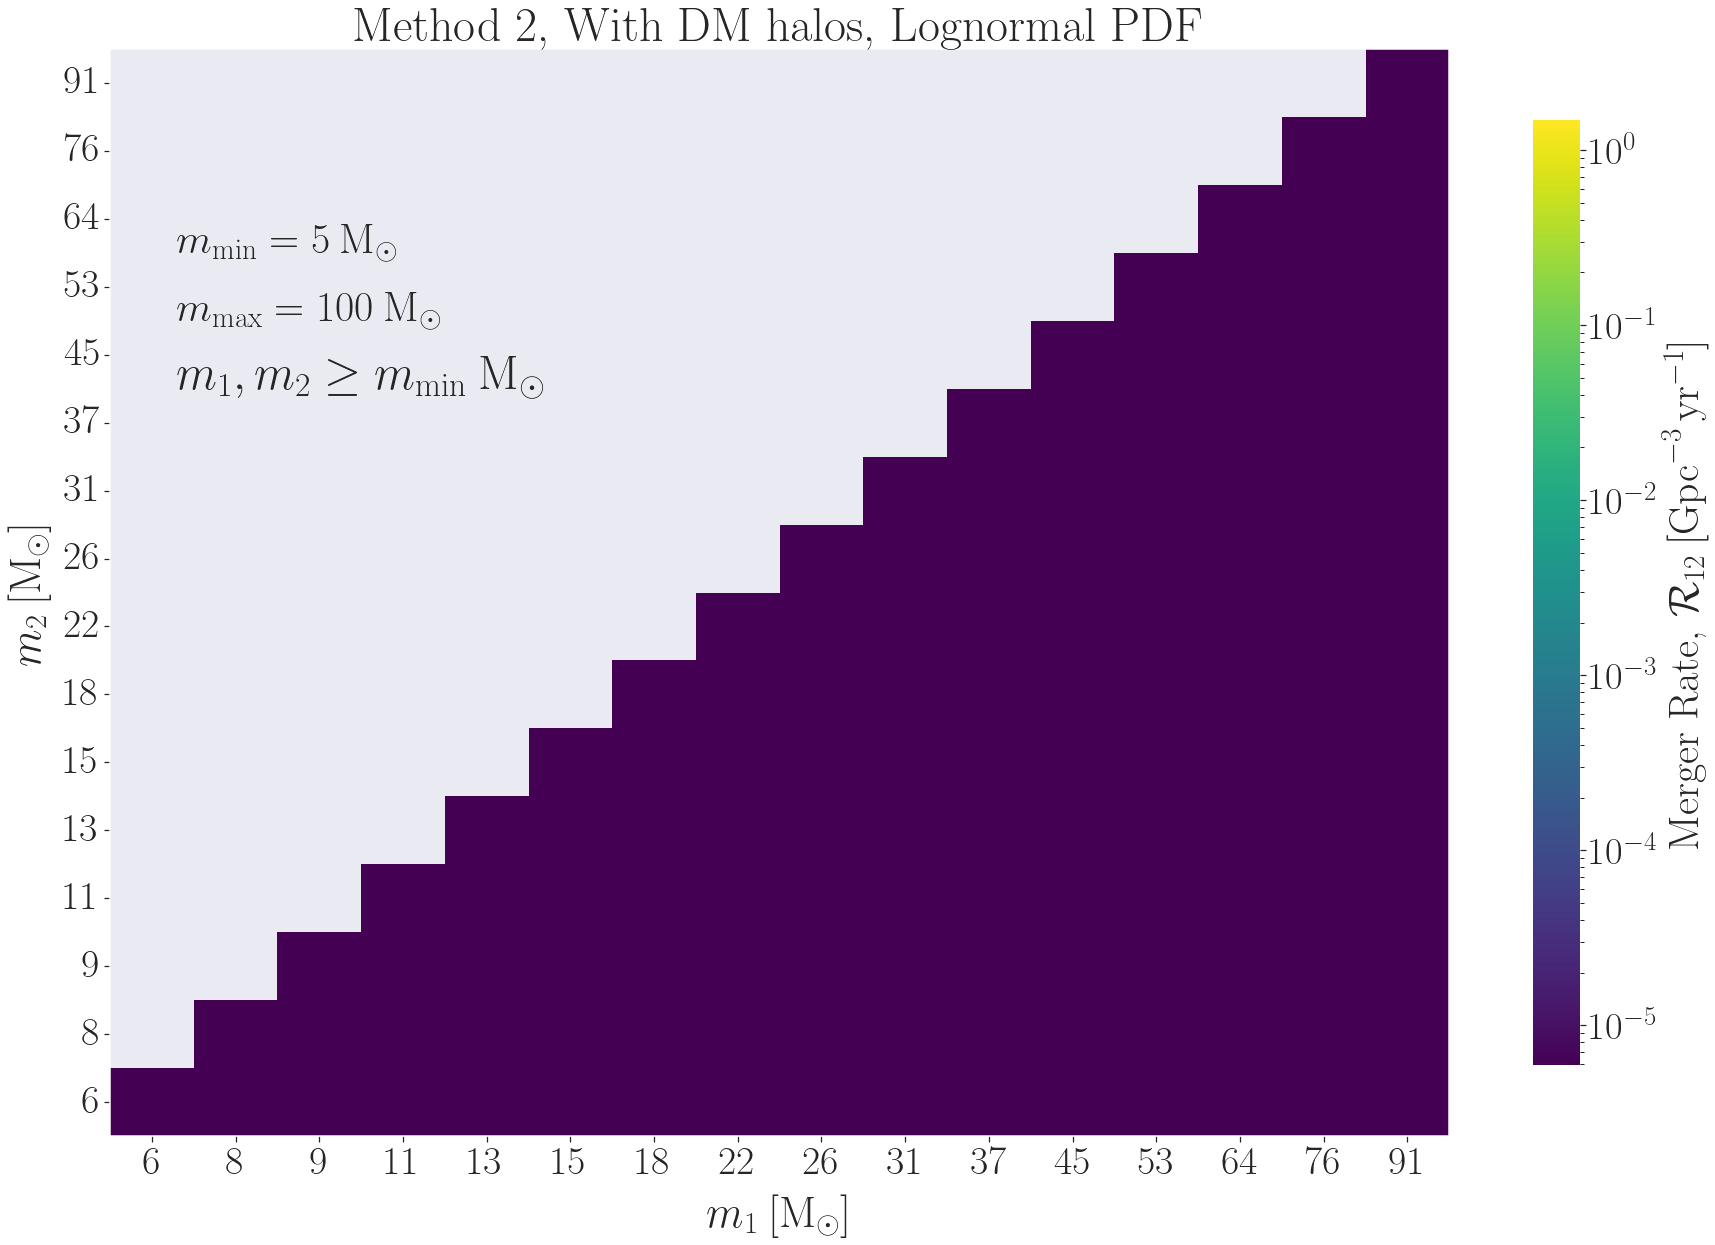

In [32]:
# Plot for Lognormal PDF in mass range (5 - 100 ) M_sun


Merger_Lognormal_nohalo = np.load('Merger_Lognormal_nohalo.npy')
Merger_Lognormal_halo_method_2 = np.load('Merger_Lognormal_halo_method_2.npy')


mask = np.tril(np.ones((16, 16)),k = -1)  #created an array of shape Merger_12 with all the elements in it being 0.
fig,ax = plt.subplots(figsize = (30, 20))  


sns.set(font_scale = 3.5)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'




vmin = np.min(Merger_Lognormal_nohalo)
vmax = np.max(Merger_Lognormal_nohalo)
norm = LogNorm(vmin, vmax)


ax = sns.heatmap(Merger_Lognormal_halo_method_2, mask = mask,  cmap = 'viridis', cbar = True, norm = norm,
                 cbar_kws = {"shrink": 0.87,'label': 'Merger Rate, $\mathcal{R}_{12} \: [\mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1}]$'})


ax.set_xticklabels(m_1_list, fontsize = 10)
ax.set_yticklabels(m_2_list, rotation = 360, fontsize = 10)
ax.tick_params(left = True, bottom = True)


ax.text(0.8, 13, "$m_\mathrm{{min}} = 5 \: \mathrm{M_{\odot}}$", size = 42)
ax.text(0.8, 12, "$m_\mathrm{{max}} = 100 \: \mathrm{M_{\odot}}$", size = 42)
ax.text(0.8, 11, "$m_{1}, m_{2} \geq m_\mathrm{min} \: \mathrm{M_{\odot}}$", size = 48)



# make frame visible
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1.5)


ax.invert_yaxis()
plt.xticks(fontsize = 40)
plt.yticks(fontsize = 40)
plt.xlabel('$m_{1}\: [\mathrm{M_{\odot}}]$', fontsize = 44, labelpad = 13)
plt.ylabel('$m_{2}\: [\mathrm{M_{\odot}}]$', fontsize = 44, labelpad = 13)
plt.title('Method 2, With DM halos, Lognormal PDF', fontsize = 48, pad = 9)
plt.savefig('1hLogNormalDM.pdf', bbox_inches = 'tight')
plt.show()     

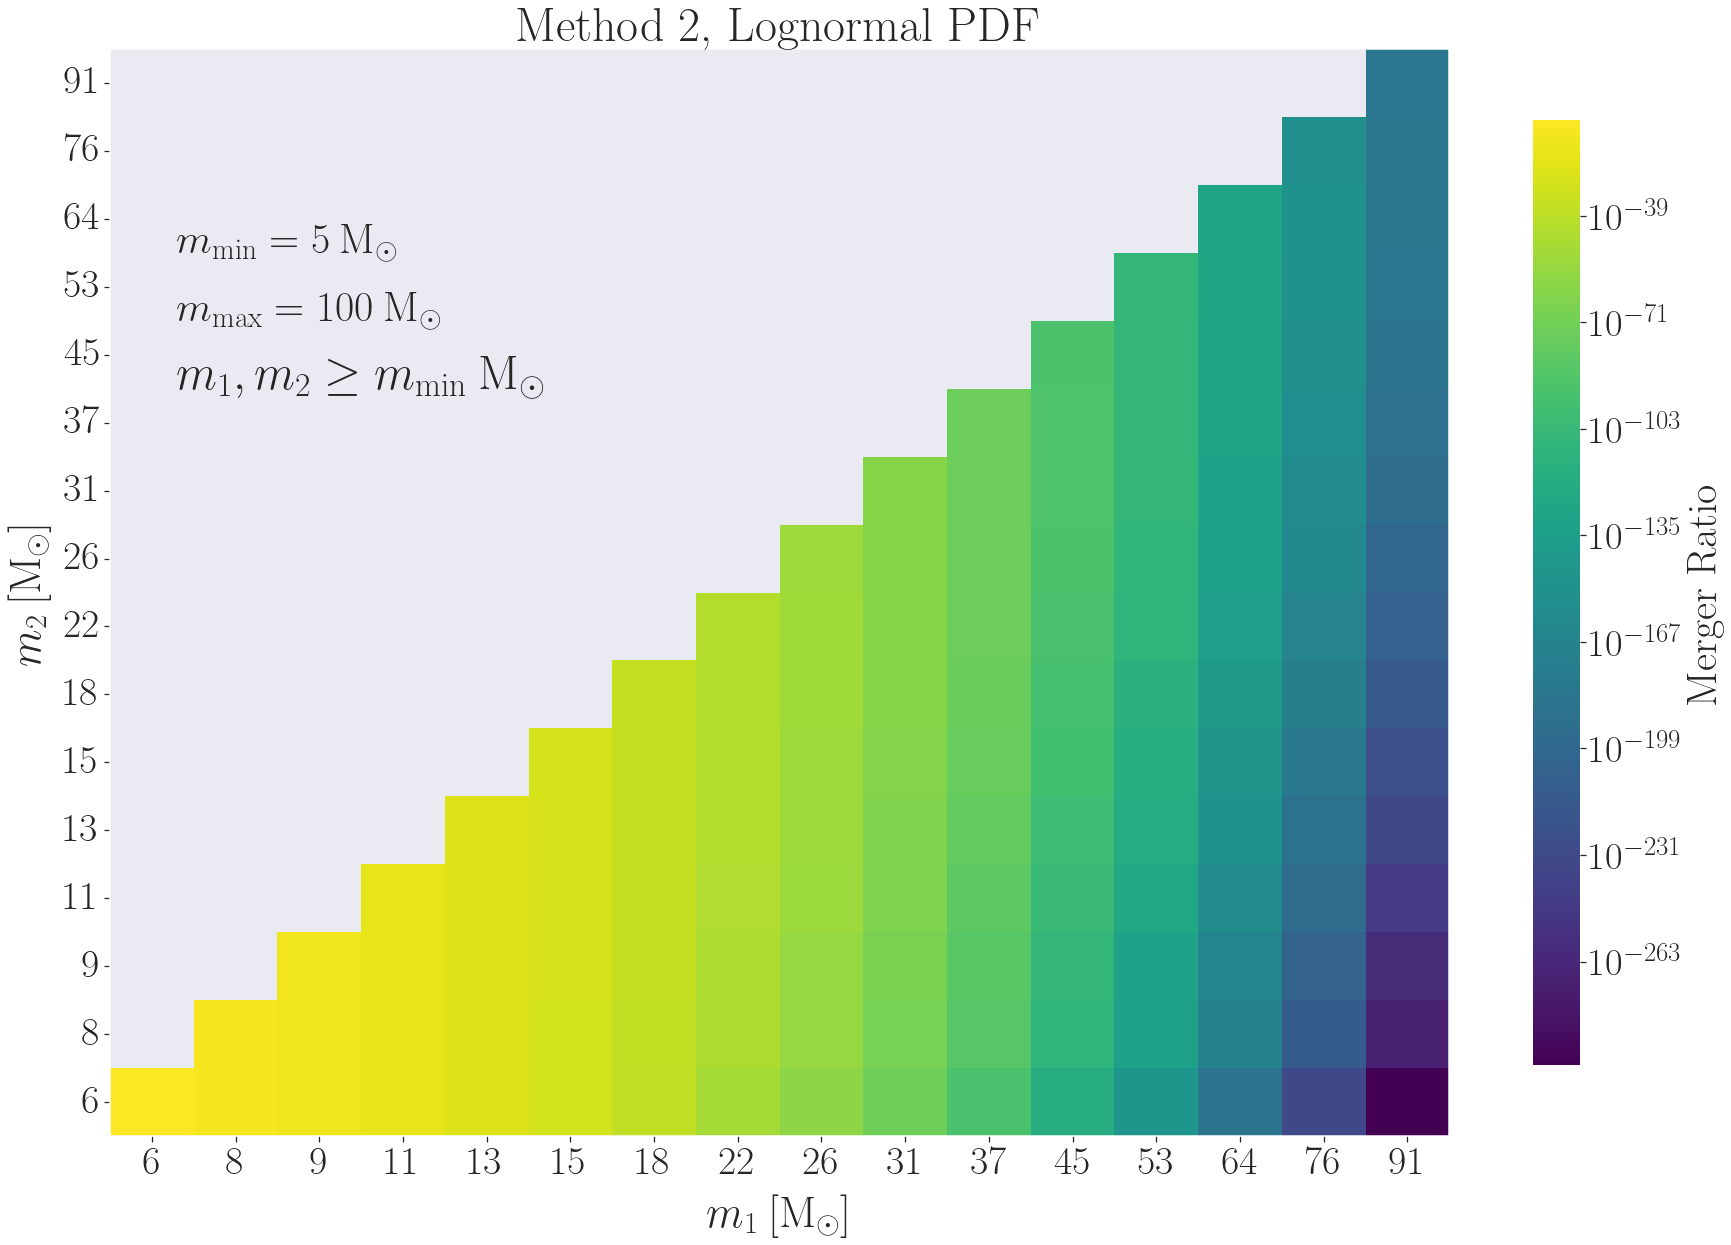

In [33]:
# Ratio of merger rate for binaries with and without DM halos for
# Lognormal PDF in mass range (5 - 100) M_sun.


Merger_Lognormal_nohalo = np.load('Merger_Lognormal_nohalo.npy')
Merger_Lognormal_halo_method_2 = np.load('Merger_Lognormal_halo_method_2.npy')



Merger_Lognormal_ratio_1 = np.divide(Merger_Lognormal_halo_method_2, Merger_Lognormal_nohalo)

mask = np.tril(np.ones((16,  16)), k = -1)  #created an array of shape Merger_12 with all the elements in it being 0.
fig,ax = plt.subplots(figsize = (30, 20))  




sns.set(font_scale = 3.5)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'



vmin = np.min(Merger_Lognormal_ratio_1)
vmax = np.max(Merger_Lognormal_ratio_1)
norm = LogNorm(vmin, vmax)



ax = sns.heatmap(Merger_Lognormal_ratio_1, mask = mask,  cmap = 'viridis', cbar = True,  norm = norm, 
                 cbar_kws = { "shrink": 0.87, 'label': 'Merger Ratio'})




ax.set_xticklabels(m_1_list, fontsize = 10)
ax.set_yticklabels(m_2_list, rotation = 360, fontsize = 10)
ax.tick_params(left = True,  bottom = True)

ax.text(0.8, 13, "$m_\mathrm{{min}} = 5 \: \mathrm{M_{\odot}}$", size = 42)
ax.text(0.8, 12, "$m_\mathrm{{max}} = 100 \: \mathrm{M_{\odot}}$", size = 42)
ax.text(0.8, 11, "$m_{1}, m_{2} \geq m_\mathrm{min} \: \mathrm{M_{\odot}}$", size = 48)



# make frame visible
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1.5)
    
    
ax.invert_yaxis()
plt.xticks(fontsize = 40)
plt.yticks(fontsize = 40)
plt.xlabel('$m_{1}\:[\mathrm{M_{\odot}}]$', fontsize = 44, labelpad = 13)     # m_j = m_2
plt.ylabel('$m_{2}\: [\mathrm{M_{\odot}}]$', fontsize = 44, labelpad = 13)    # m_i = m_1  and m_2 < equal to m_1.
plt.title(' Method 2, Lognormal PDF', fontsize = 48, pad = 9)
plt.savefig('1rLogNormalPDF.pdf', bbox_inches = 'tight')
plt.show()     

In [ ]:
# Merger rates plots for Power Law of PBH masses from m_min = 1e-2 M☉ - m_max = 100 M☉. 

In [34]:
bin_centres = np.geomspace(2e-2, 78, 16)
bin_edges = np.sqrt(bin_centres[:-1]*bin_centres[1:])


ratio = bin_edges[1]/bin_edges[0] 
bin_edges = np.append(bin_edges[0]/ratio, bin_edges) 
bin_edges = np.append(bin_edges, bin_edges[-1]*ratio) 


deltas = np.diff(bin_edges)




Δ_1_list = deltas.tolist()
Δ_2_list = deltas.tolist()



m_1 = np.geomspace(2e-2, 78, 16)
m_2 = np.geomspace(2e-2, 78, 16)


m_1_list = m_1.tolist()
m_2_list = m_2.tolist()   



m_1_list = list(map(lambda x: float(format(x, '.2f')), m_1_list))   
m_2_list = list(map(lambda x: float(format(x, '.2f')), m_2_list)) 
 
 
    
    
m_1_list = [0.02, 0.03, 0.06, 0.1, 0.2, 0.3, 0.6, 1, 2, 3, 5, 9, 15, 26, 45, 78]  
m_2_list = [0.02, 0.03, 0.06, 0.1, 0.2, 0.3, 0.6, 1, 2, 3, 5, 9, 15, 26, 45, 78] 


Δ_1_list = list(map(lambda x: float(format(x, '.8f')),  Δ_1_list))   
Δ_2_list = list(map(lambda x: float(format(x, '.8f')),  Δ_2_list)) 
    

print('\v')
print("m_1 =", m_1_list, "M☉")
print('\v')
print("Δ_1 =", Δ_1_list)


m_min = 1e-2  #in units of M☉
m_max = 100   #in units of M☉

X_min = 1e-5
X_max = 1e5


m_1 = [0.02, 0.03, 0.06, 0.1, 0.2, 0.3, 0.6, 1, 2, 3, 5, 9, 15, 26, 45, 78] M☉

Δ_1 = [0.0111651, 0.01937612, 0.03362569, 0.05835466, 0.10126977, 0.17574547, 0.30499199, 0.52928885, 0.91853783, 1.59404786, 2.76634068, 4.80075972, 8.33132886, 14.45834503, 25.09128432, 43.54388745]


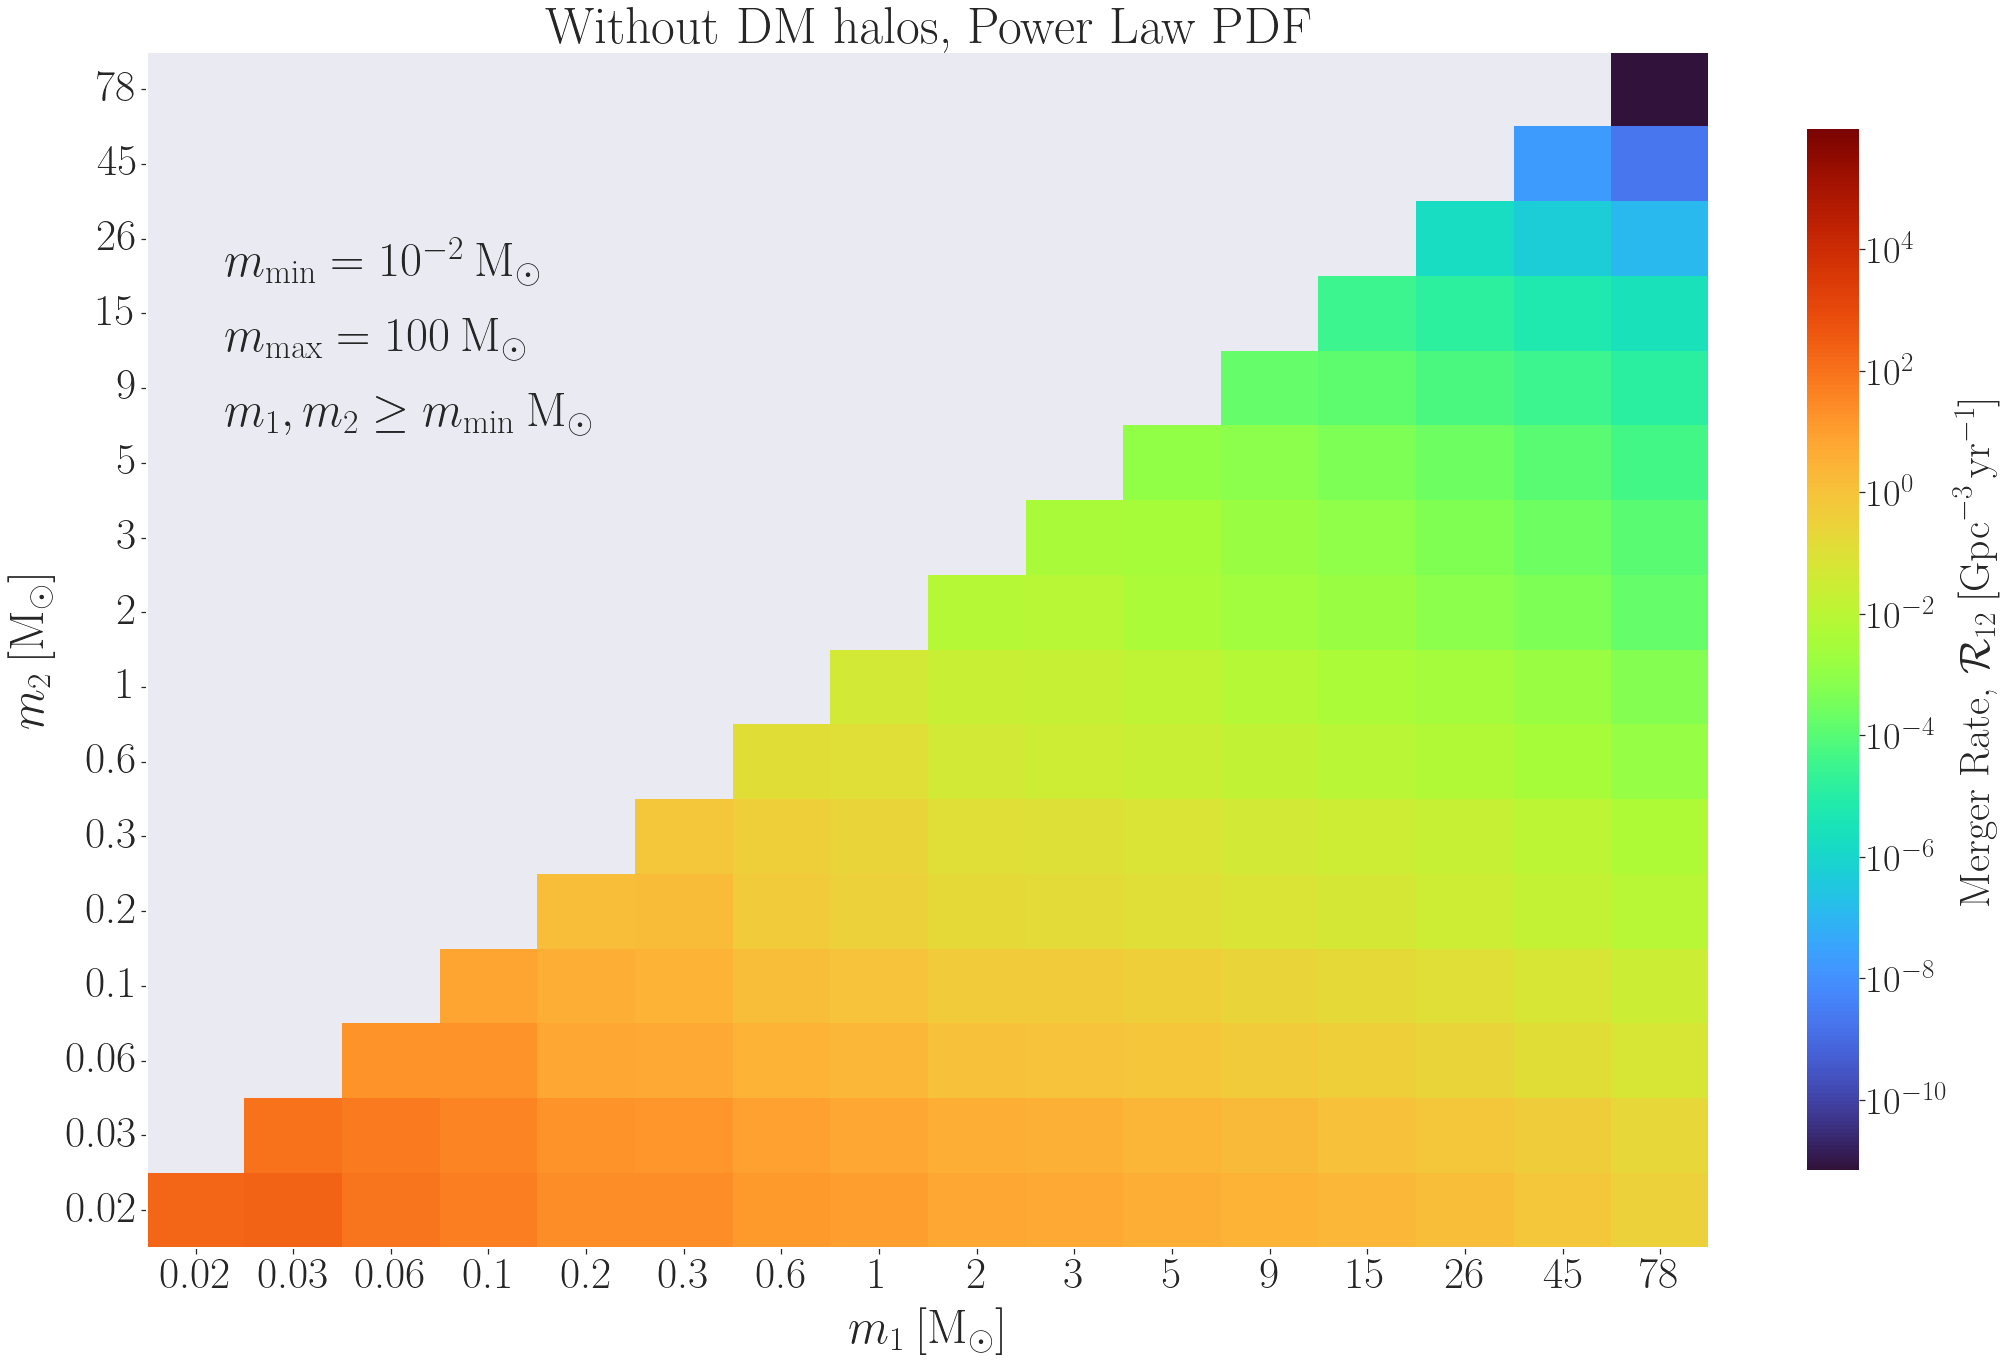

In [36]:
# Plot of merger rate for Power Law PDF in mass range (1e-2 - 100) M_sun

Merger_PWR_nohalo = np.load('Merger_PWR_nohalo.npy')
Merger_PWR_halo_method_2 = np.load('Merger_PWR_halo_method_2.npy')



mask = np.tril(np.ones((16, 16)), k = -1)  #created an array of shape Merger_12 with all the elements in it being 0.
fig,ax = plt.subplots(figsize=(35, 22))  


sns.set(font_scale = 3.5)
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['font.family'] = 'serif'


vmin = np.min(Merger_PWR_nohalo)
vmax = np.max(Merger_PWR_halo_method_2)
norm = LogNorm(vmin, vmax)



ax = sns.heatmap(Merger_PWR_nohalo, mask = mask,  cmap = 'turbo', cbar = True, norm = norm,
                 cbar_kws = {"shrink": 0.87, 'label': 'Merger Rate, $\mathcal{R}_{12} \: [\mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1}]$'},
                 fmt = '0.8f')



ax.set_xticklabels(m_1_list, fontsize = 200)
ax.set_yticklabels(m_2_list,rotation = 360, fontsize = 200)
ax.tick_params(left=True, bottom=True)


ax.text(0.8, 13, "$m_\mathrm{{min}} = 10^{-2} \: \mathrm{M_{\odot}}$", size = 48)
ax.text(0.8, 12, "$m_\mathrm{{max}} = 100 \: \mathrm{M_{\odot}}$", size = 48)
ax.text(0.8, 11, "$m_{1}, m_{2} \geq m_\mathrm{min} \: \mathrm{M_{\odot}}$", size = 48)



# Drawing the frame
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(2)


ax.invert_yaxis()
plt.xticks(fontsize = 44)
plt.yticks(fontsize = 44)
plt.xlabel('$m_{1}\:[\mathrm{M_{\odot}}]$', fontsize = 48, labelpad = 11)   # m_j = m_2
plt.ylabel('$m_{2}\: [\mathrm{M_{\odot}}]$', fontsize = 48, labelpad = 11)  # m_i = m_1  and m_2< equal to m_1.
plt.title('Without DM halos, Power Law PDF', fontsize = 52, pad = 9)
plt.savefig('1PWRLawnoDM.pdf', bbox_inches = 'tight')
plt.show()     

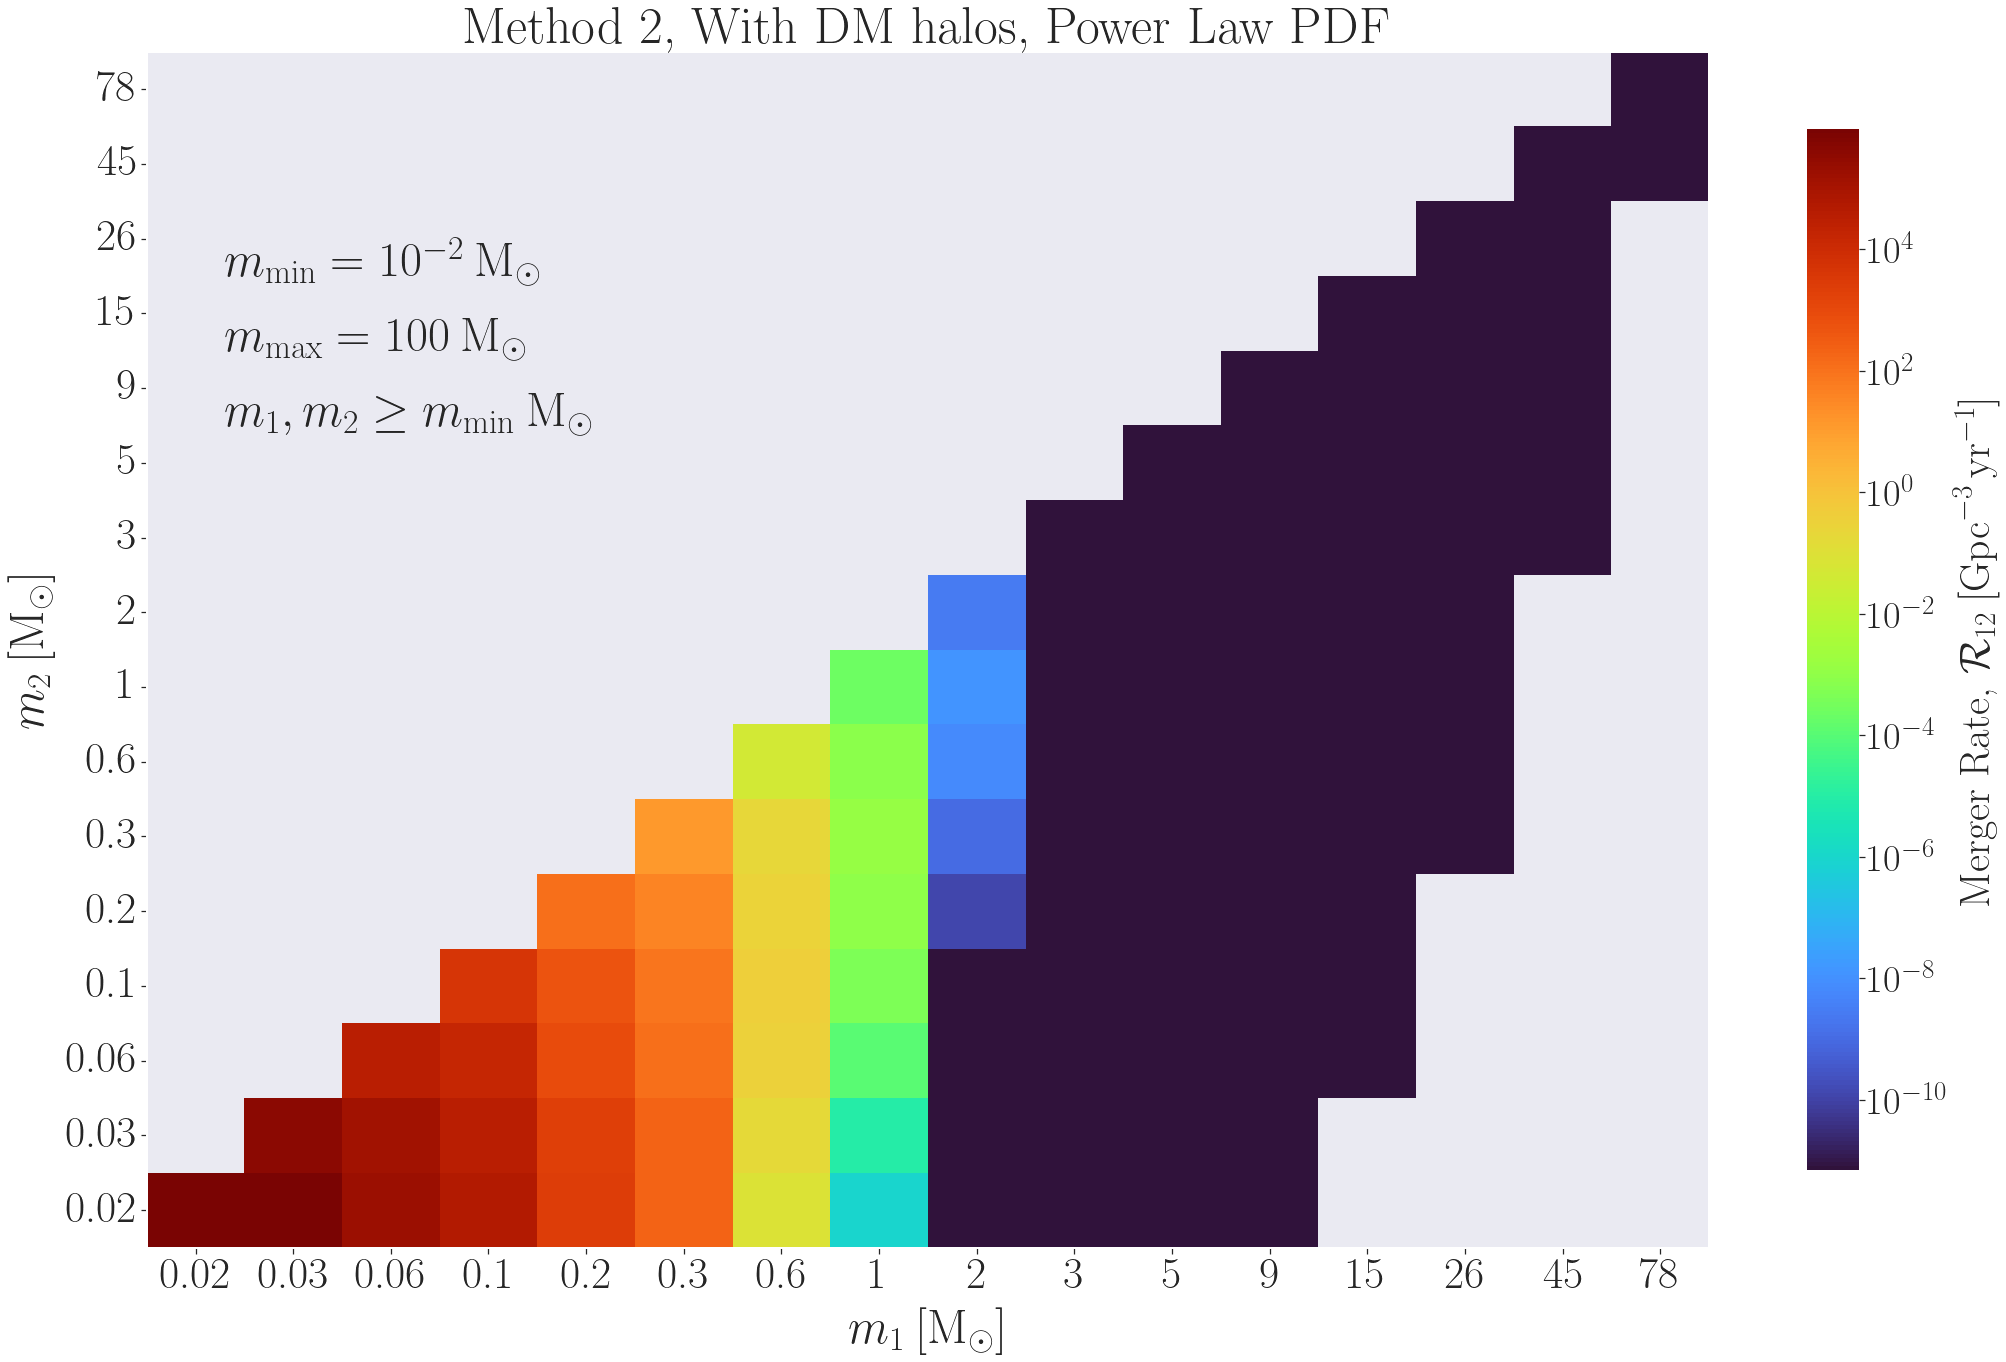

In [38]:
# Plot of merger rate for Power Law PDF in mass range (1e-2 - 100) M_sun



Merger_PWR_nohalo = np.load('Merger_PWR_nohalo.npy')
Merger_PWR_halo_method_2 = np.load('Merger_PWR_halo_method_2.npy')



mask = np.tril(np.ones((16, 16)), k = -1)  #created an array of shape Merger_12 with all the elements in it being 0.
fig,ax = plt.subplots(figsize=(35, 22))  


sns.set(font_scale = 3.5)
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['font.family'] = 'serif'


vmin = np.min(Merger_PWR_nohalo)
vmax = np.max(Merger_PWR_halo_method_2)
norm = LogNorm(vmin, vmax)



ax = sns.heatmap(Merger_PWR_halo_method_2, mask = mask,  cmap = 'turbo', cbar = True, norm = norm,
                 cbar_kws = {"shrink": 0.87, 'label': 'Merger Rate, $\mathcal{R}_{12} \: [\mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1}]$'},
                 fmt = '0.8f')



ax.set_xticklabels(m_1_list, fontsize = 200)
ax.set_yticklabels(m_2_list,rotation = 360, fontsize = 200)
ax.tick_params(left=True, bottom=True)


ax.text(0.8, 13, "$m_\mathrm{{min}} = 10^{-2} \: \mathrm{M_{\odot}}$", size = 48)
ax.text(0.8, 12, "$m_\mathrm{{max}} = 100 \: \mathrm{M_{\odot}}$", size = 48)
ax.text(0.8, 11, "$m_{1}, m_{2} \geq m_\mathrm{min} \: \mathrm{M_{\odot}}$", size = 48)



# Drawing the frame
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(2)


ax.invert_yaxis()
plt.xticks(fontsize = 44)
plt.yticks(fontsize = 44)
plt.xlabel('$m_{1}\:[\mathrm{M_{\odot}}]$', fontsize = 48, labelpad = 11)   # m_j = m_2
plt.ylabel('$m_{2}\: [\mathrm{M_{\odot}}]$', fontsize = 48, labelpad = 11)  # m_i = m_1  and m_2< equal to m_1.
plt.title('Method 2, With DM halos, Power Law PDF', fontsize = 52, pad = 9)
plt.savefig('1hPWRLawDM.pdf', bbox_inches = 'tight')
plt.show()     

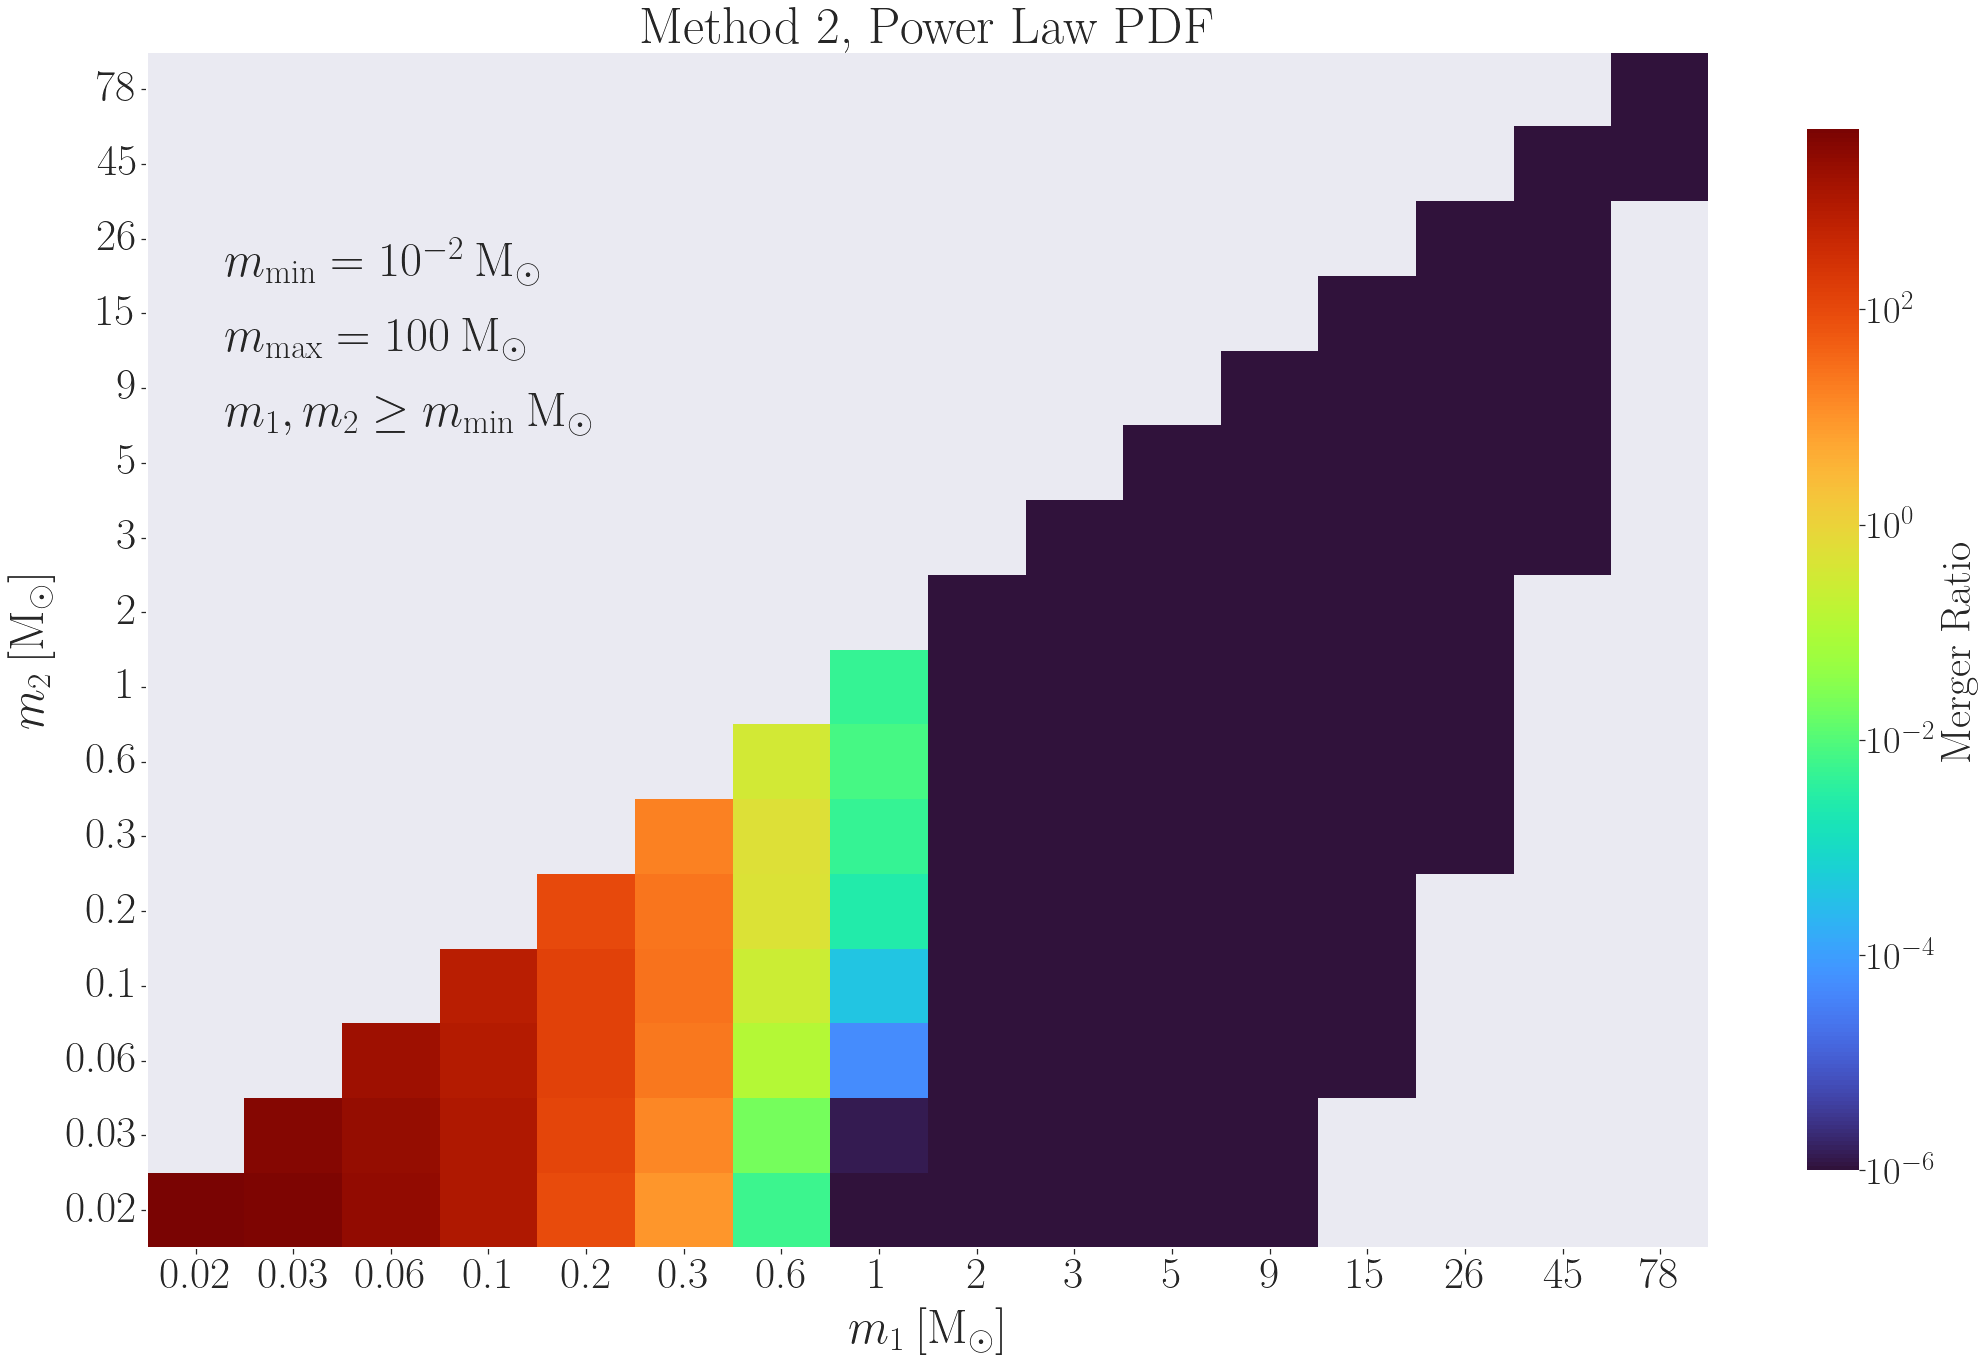

In [39]:
# Ratio of merger rate for binaries with and without DM halos for
# Power Law PDF in mass range (1e-2 - 100) M_sun.


Merger_PWR_nohalo = np.load('Merger_PWR_nohalo.npy')
Merger_PWR_halo_method_2 = np.load('Merger_PWR_halo_method_2.npy')

Merger_PWR_ratio_1 = np.divide(Merger_PWR_halo_method_2, Merger_PWR_nohalo)


mask = np.tril(np.ones((16, 16)), k = -1)  #created an array of shape Merger_12 with all the elements in it being 0.
fig,ax = plt.subplots(figsize=(35, 22))  


sns.set(font_scale = 3.5)
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['font.family'] = 'serif'


vmin = 1e-6
vmax = np.max(Merger_PWR_ratio_1)
norm = LogNorm(vmin, vmax)



ax = sns.heatmap(Merger_PWR_ratio_1, mask = mask,  cmap = 'turbo', cbar = True, norm = norm,
                 cbar_kws = {"shrink": 0.87, 'label': 'Merger Ratio'},
                 fmt = '0.8f')



ax.set_xticklabels(m_1_list, fontsize = 200)
ax.set_yticklabels(m_2_list,rotation = 360, fontsize = 200)
ax.tick_params(left=True, bottom=True)


ax.text(0.8, 13, "$m_\mathrm{{min}} = 10^{-2} \: \mathrm{M_{\odot}}$", size = 48)
ax.text(0.8, 12, "$m_\mathrm{{max}} = 100 \: \mathrm{M_{\odot}}$", size = 48)
ax.text(0.8, 11, "$m_{1}, m_{2} \geq m_\mathrm{min} \: \mathrm{M_{\odot}}$", size = 48)



# Drawing the frame
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(2)


ax.invert_yaxis()
plt.xticks(fontsize = 44)
plt.yticks(fontsize = 44)
plt.xlabel('$m_{1}\:[\mathrm{M_{\odot}}]$', fontsize = 48, labelpad = 11)   # m_j = m_2
plt.ylabel('$m_{2}\: [\mathrm{M_{\odot}}]$', fontsize = 48, labelpad = 11)  # m_i = m_1  and m_2< equal to m_1.
plt.title('Method 2, Power Law PDF', fontsize = 52, pad = 9)
plt.savefig('1rPWRLawPDF.pdf', bbox_inches = 'tight')
plt.show()     

In [ ]:
# Merger rates plots for the range of PBH masses from m_min = 1e-4 M☉ - m_max = 100 M☉ using
# mass function of the paper https://arxiv.org/abs/2207.07576 . 

In [40]:
bin_centres = np.geomspace(2e-4, 69, 16)
bin_edges = np.sqrt(bin_centres[:-1]*bin_centres[1:])


ratio = bin_edges[1]/bin_edges[0] 
bin_edges = np.append(bin_edges[0]/ratio, bin_edges) 
bin_edges = np.append(bin_edges, bin_edges[-1]*ratio) 


deltas = np.diff(bin_edges)




Δ_1_list = deltas.tolist()
Δ_2_list = deltas.tolist()



m_1 = np.geomspace(2e-4, 69, 16)
m_2 = np.geomspace(2e-4, 69, 16)


m_1_list = m_1.tolist()
m_2_list = m_2.tolist()   



m_1_list = list(map(lambda x: float(format(x, '.4f')), m_1_list))   
m_2_list = list(map(lambda x: float(format(x, '.4f')), m_2_list)) 



m_1_list = [0.0002, 0.0005, 0.001, 0.003, 0.006, 0.01, 0.03, 0.08, 0.2, 0.4, 1, 2, 5, 
             12, 29, 69] 


m_2_list = [0.0002, 0.0005, 0.001, 0.003, 0.006, 0.01, 0.03, 0.08, 0.2, 0.4, 1, 2, 5,  
             12, 29, 69]



Δ_1_list = list(map(lambda x: float(format(x, '.8f')),  Δ_1_list))   
Δ_2_list = list(map(lambda x: float(format(x, '.8f')),  Δ_2_list)) 
    

print('\v')
print("m_1 =", m_1_list, "M☉")
print('\v')
print("Δ_1 =", Δ_1_list)

m_min = 1e-4
m_max = 100

X_min = 1e-5
X_max = 1e5


m_1 = [0.0002, 0.0005, 0.001, 0.003, 0.006, 0.01, 0.03, 0.08, 0.2, 0.4, 1, 2, 5, 12, 29, 69] M☉

Δ_1 = [0.00017518, 0.0004099, 0.00095911, 0.00224417, 0.00525102, 0.0122866, 0.0287488, 0.06726787, 0.15739669, 0.36828457, 0.86173051, 2.01631977, 4.71788496, 11.03914116, 25.82992984, 60.43815056]


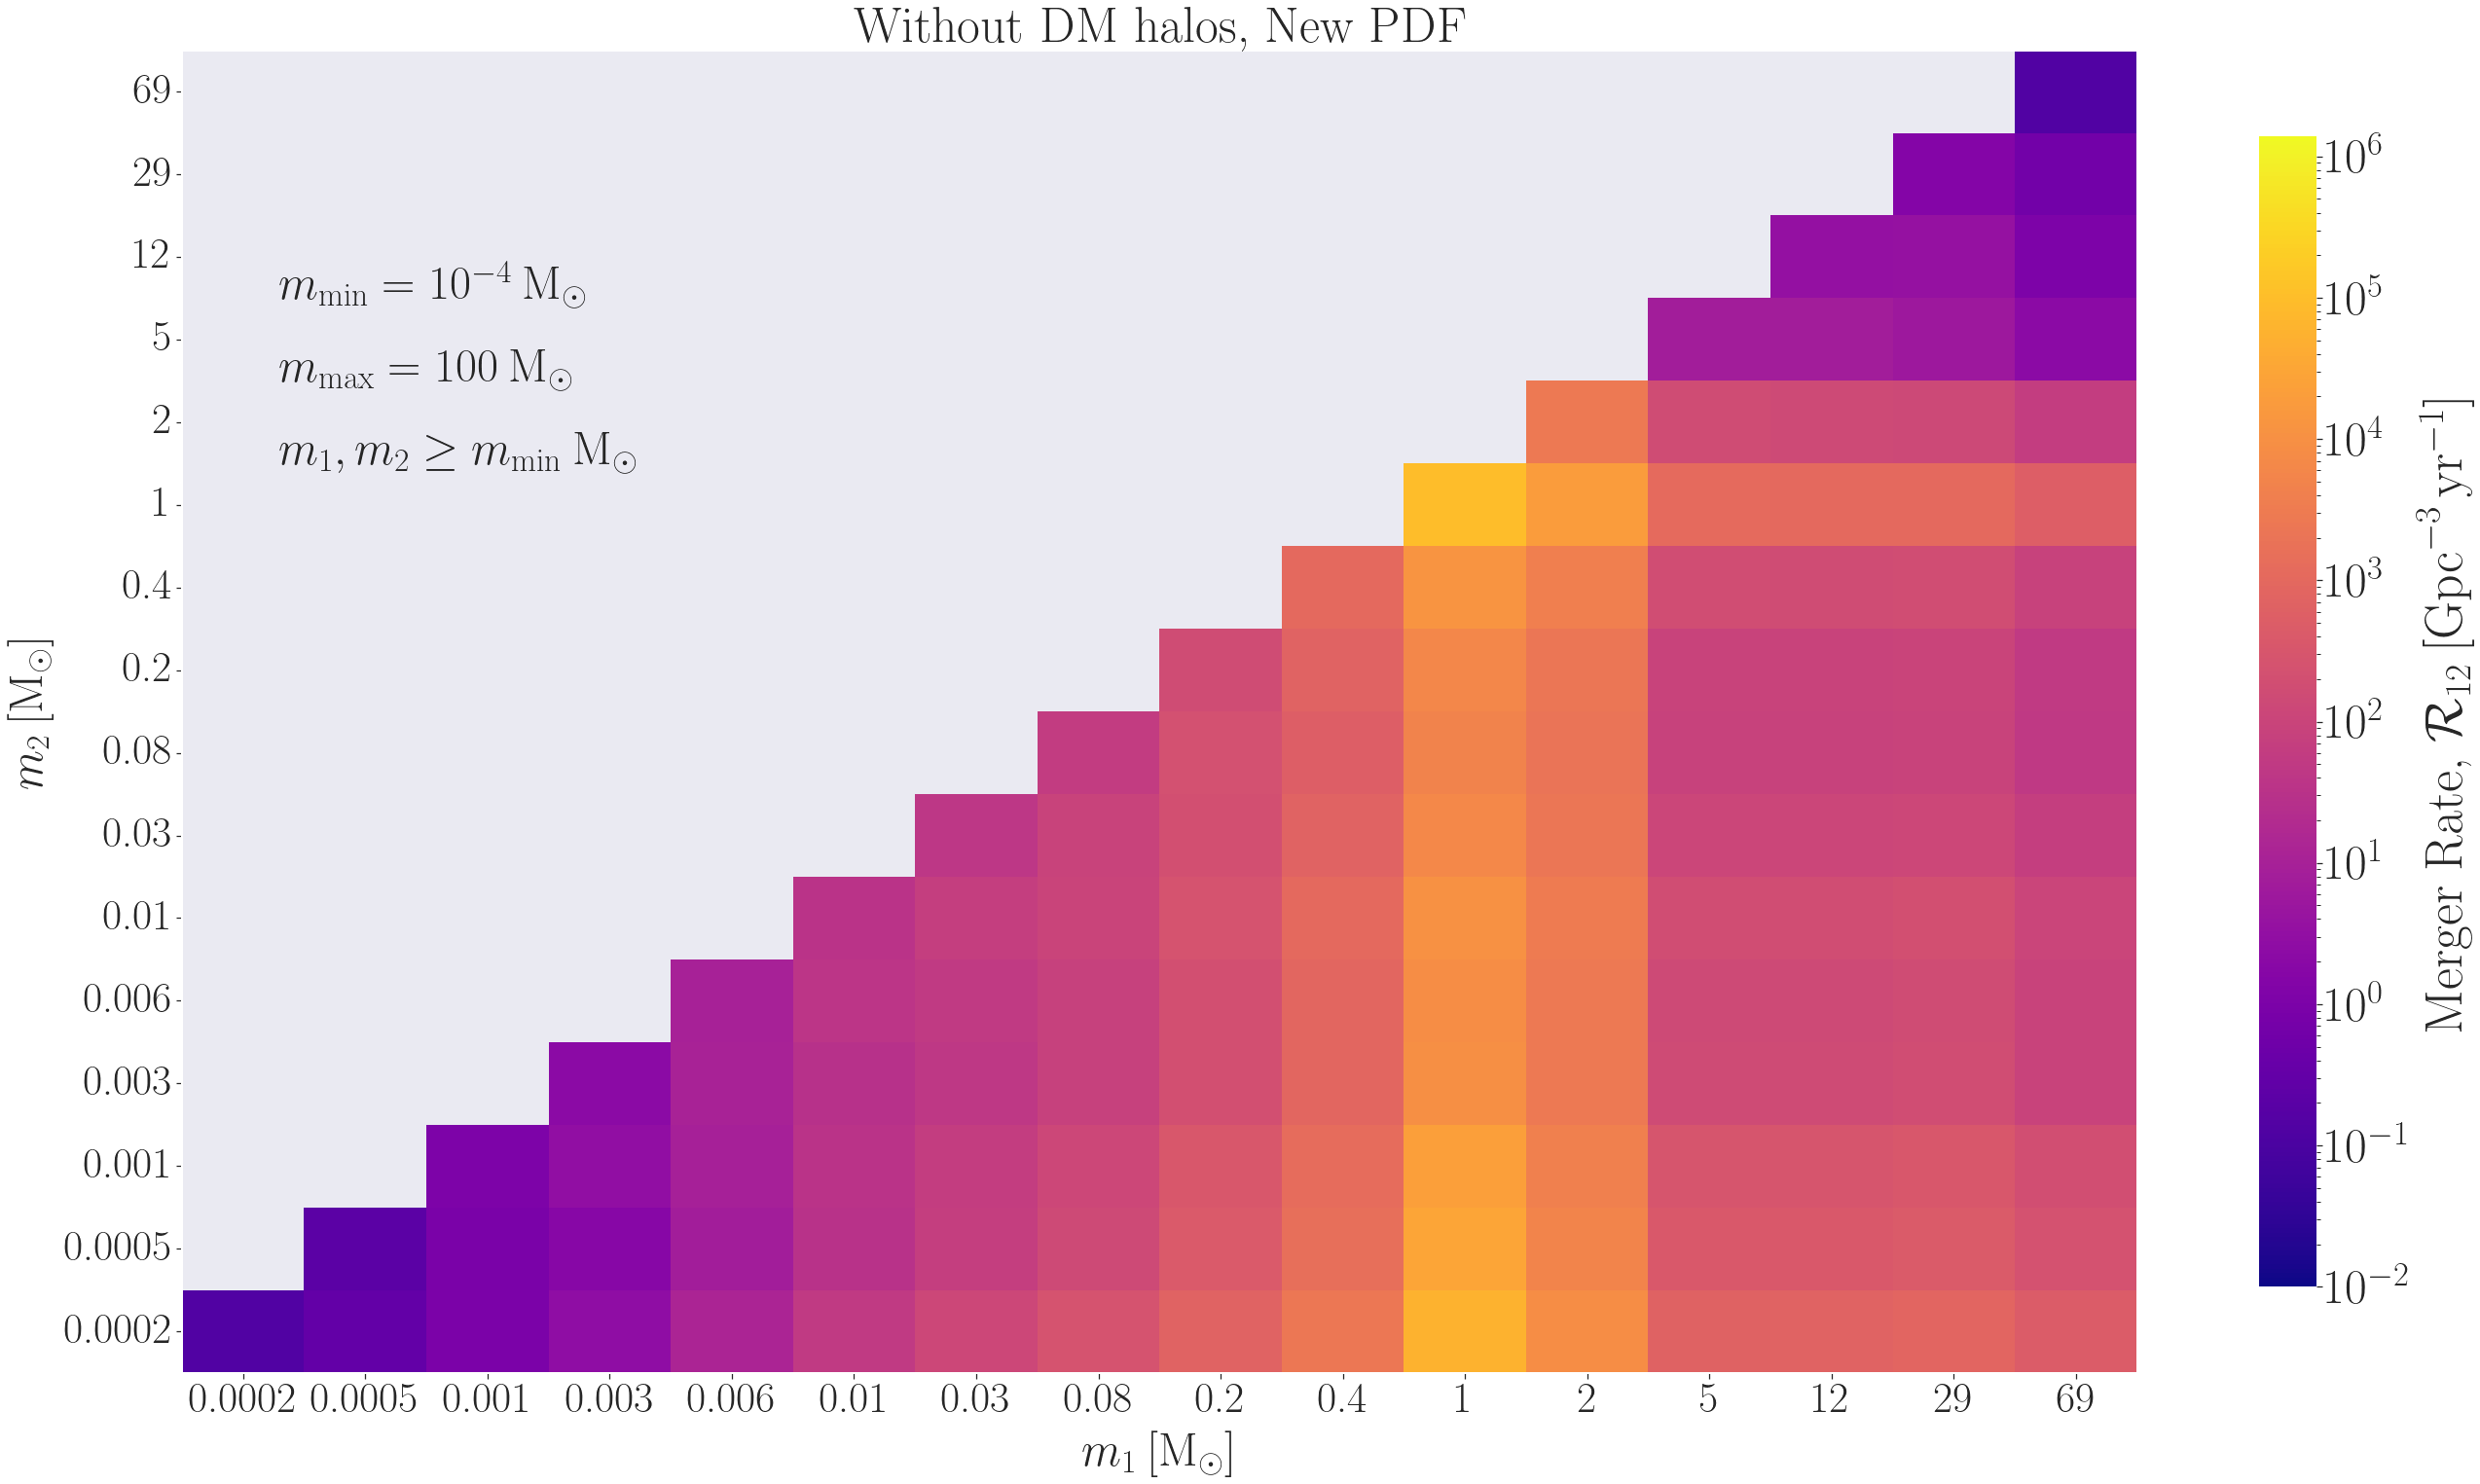

In [45]:
# Plot of merger rate for PDF of the paper https://arxiv.org/abs/2207.07576 . 

Merger_new_PDF_nohalo = np.load('Merger_new_PDF_nohalo.npy')
Merger_new_PDF_halo_method_2 = np.load('Merger_new_PDF_halo_method_2.npy')



mask = np.tril(np.ones((16, 16)), k = -1)  #created an array of shape Merger_12 with all the elements in it being 0.
fig,ax = plt.subplots(figsize=(45, 25))  


sns.set(font_scale = 4.5)
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['font.family'] = 'serif'


vmin = 1e-2
vmax = np.max(Merger_new_PDF_halo_method_2)
norm = LogNorm(vmin, vmax)



ax = sns.heatmap(Merger_new_PDF_nohalo, mask = mask,  cmap = 'plasma', cbar = True, norm = norm,
                 cbar_kws = {"shrink": 0.87, 'label': 'Merger Rate, $\mathcal{R}_{12} \: [\mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1}]$'},
                 fmt = '0.8f')



ax.set_xticklabels(m_1_list, fontsize = 200)
ax.set_yticklabels(m_2_list,rotation = 360, fontsize = 200)
ax.tick_params(left=True, bottom=True)



ax.text(0.8, 13, "$m_\mathrm{{min}} = 10^{-4} \: \mathrm{M_{\odot}}$", size = 48)
ax.text(0.8, 12, "$m_\mathrm{{max}} = 100 \: \mathrm{M_{\odot}}$", size = 48)
ax.text(0.8, 11, "$m_{1}, m_{2} \geq m_\mathrm{min} \: \mathrm{M_{\odot}}$", size = 48)



# Drawing the frame
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(2)


ax.invert_yaxis()
plt.xticks(fontsize = 44)
plt.yticks(fontsize = 44)
plt.xlabel('$m_{1}\:[\mathrm{M_{\odot}}]$', fontsize = 48, labelpad = 11)   # m_j = m_2
plt.ylabel('$m_{2}\: [\mathrm{M_{\odot}}]$', fontsize = 48, labelpad = 11)  # m_i = m_1  and m_2< equal to m_1.
plt.title('Without DM halos, New PDF', fontsize = 52, pad = 9)
plt.savefig('1newPDFnoDM.pdf', bbox_inches = 'tight')
plt.show()     

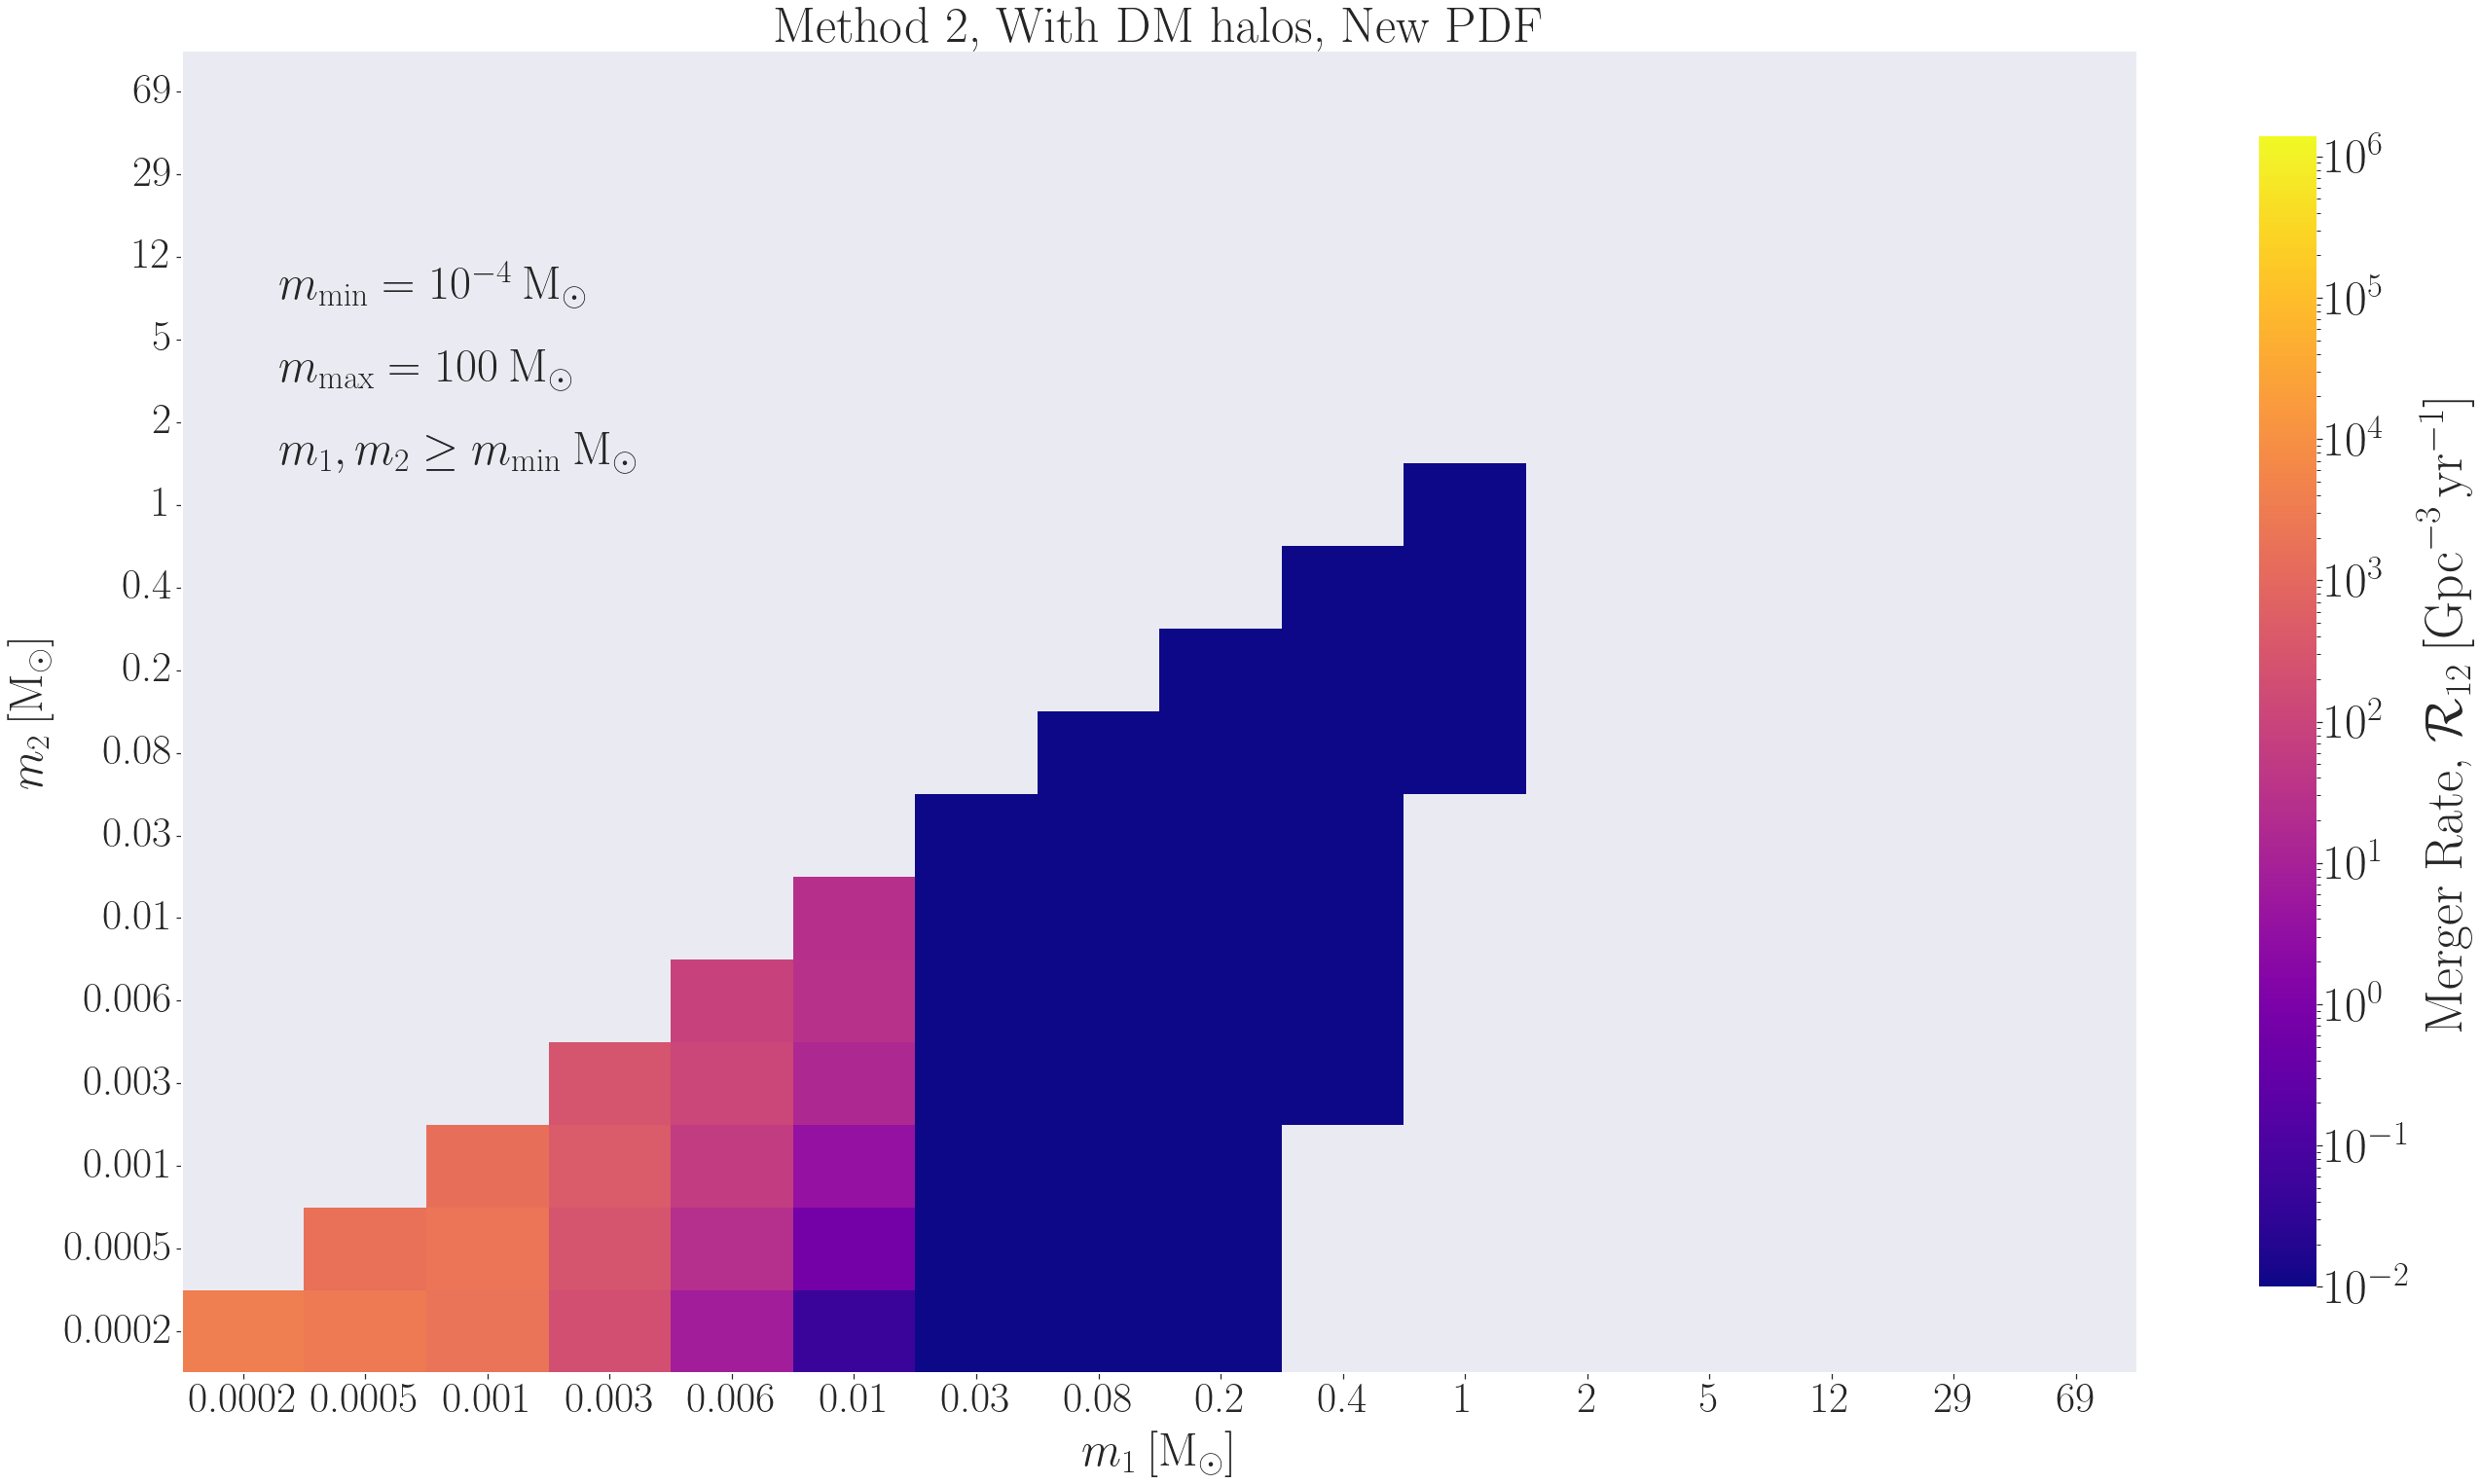

In [46]:
# Plot of merger rate for PDF of the paper https://arxiv.org/abs/2207.07576 . 


Merger_new_PDF_halo_method_2 = np.load('Merger_new_PDF_halo_method_2.npy')



mask = np.tril(np.ones((16, 16)), k = -1)  #created an array of shape Merger_12 with all the elements in it being 0.
fig,ax = plt.subplots(figsize=(45, 25))  


sns.set(font_scale = 4.5)
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['font.family'] = 'serif'


vmin = 1e-2
vmax = np.max(Merger_new_PDF_halo_method_2)
norm = LogNorm(vmin, vmax)



ax = sns.heatmap(Merger_new_PDF_halo_method_2, mask = mask,  cmap = 'plasma', cbar = True, norm = norm,
                 cbar_kws = {"shrink": 0.87, 'label': 'Merger Rate, $\mathcal{R}_{12} \: [\mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1}]$'},
                 fmt = '0.8f')



ax.set_xticklabels(m_1_list, fontsize = 200)
ax.set_yticklabels(m_2_list,rotation = 360, fontsize = 200)
ax.tick_params(left=True, bottom=True)



ax.text(0.8, 13, "$m_\mathrm{{min}} = 10^{-4} \: \mathrm{M_{\odot}}$", size = 48)
ax.text(0.8, 12, "$m_\mathrm{{max}} = 100 \: \mathrm{M_{\odot}}$", size = 48)
ax.text(0.8, 11, "$m_{1}, m_{2} \geq m_\mathrm{min} \: \mathrm{M_{\odot}}$", size = 48)



# Drawing the frame
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(2)


ax.invert_yaxis()
plt.xticks(fontsize = 44)
plt.yticks(fontsize = 44)
plt.xlabel('$m_{1}\:[\mathrm{M_{\odot}}]$', fontsize = 48, labelpad = 11)   # m_j = m_2
plt.ylabel('$m_{2}\: [\mathrm{M_{\odot}}]$', fontsize = 48, labelpad = 11)  # m_i = m_1  and m_2< equal to m_1.
plt.title('Method 2, With DM halos, New PDF', fontsize = 52, pad = 9)
plt.savefig('1hnewPDFDM.pdf', bbox_inches = 'tight')
plt.show()     

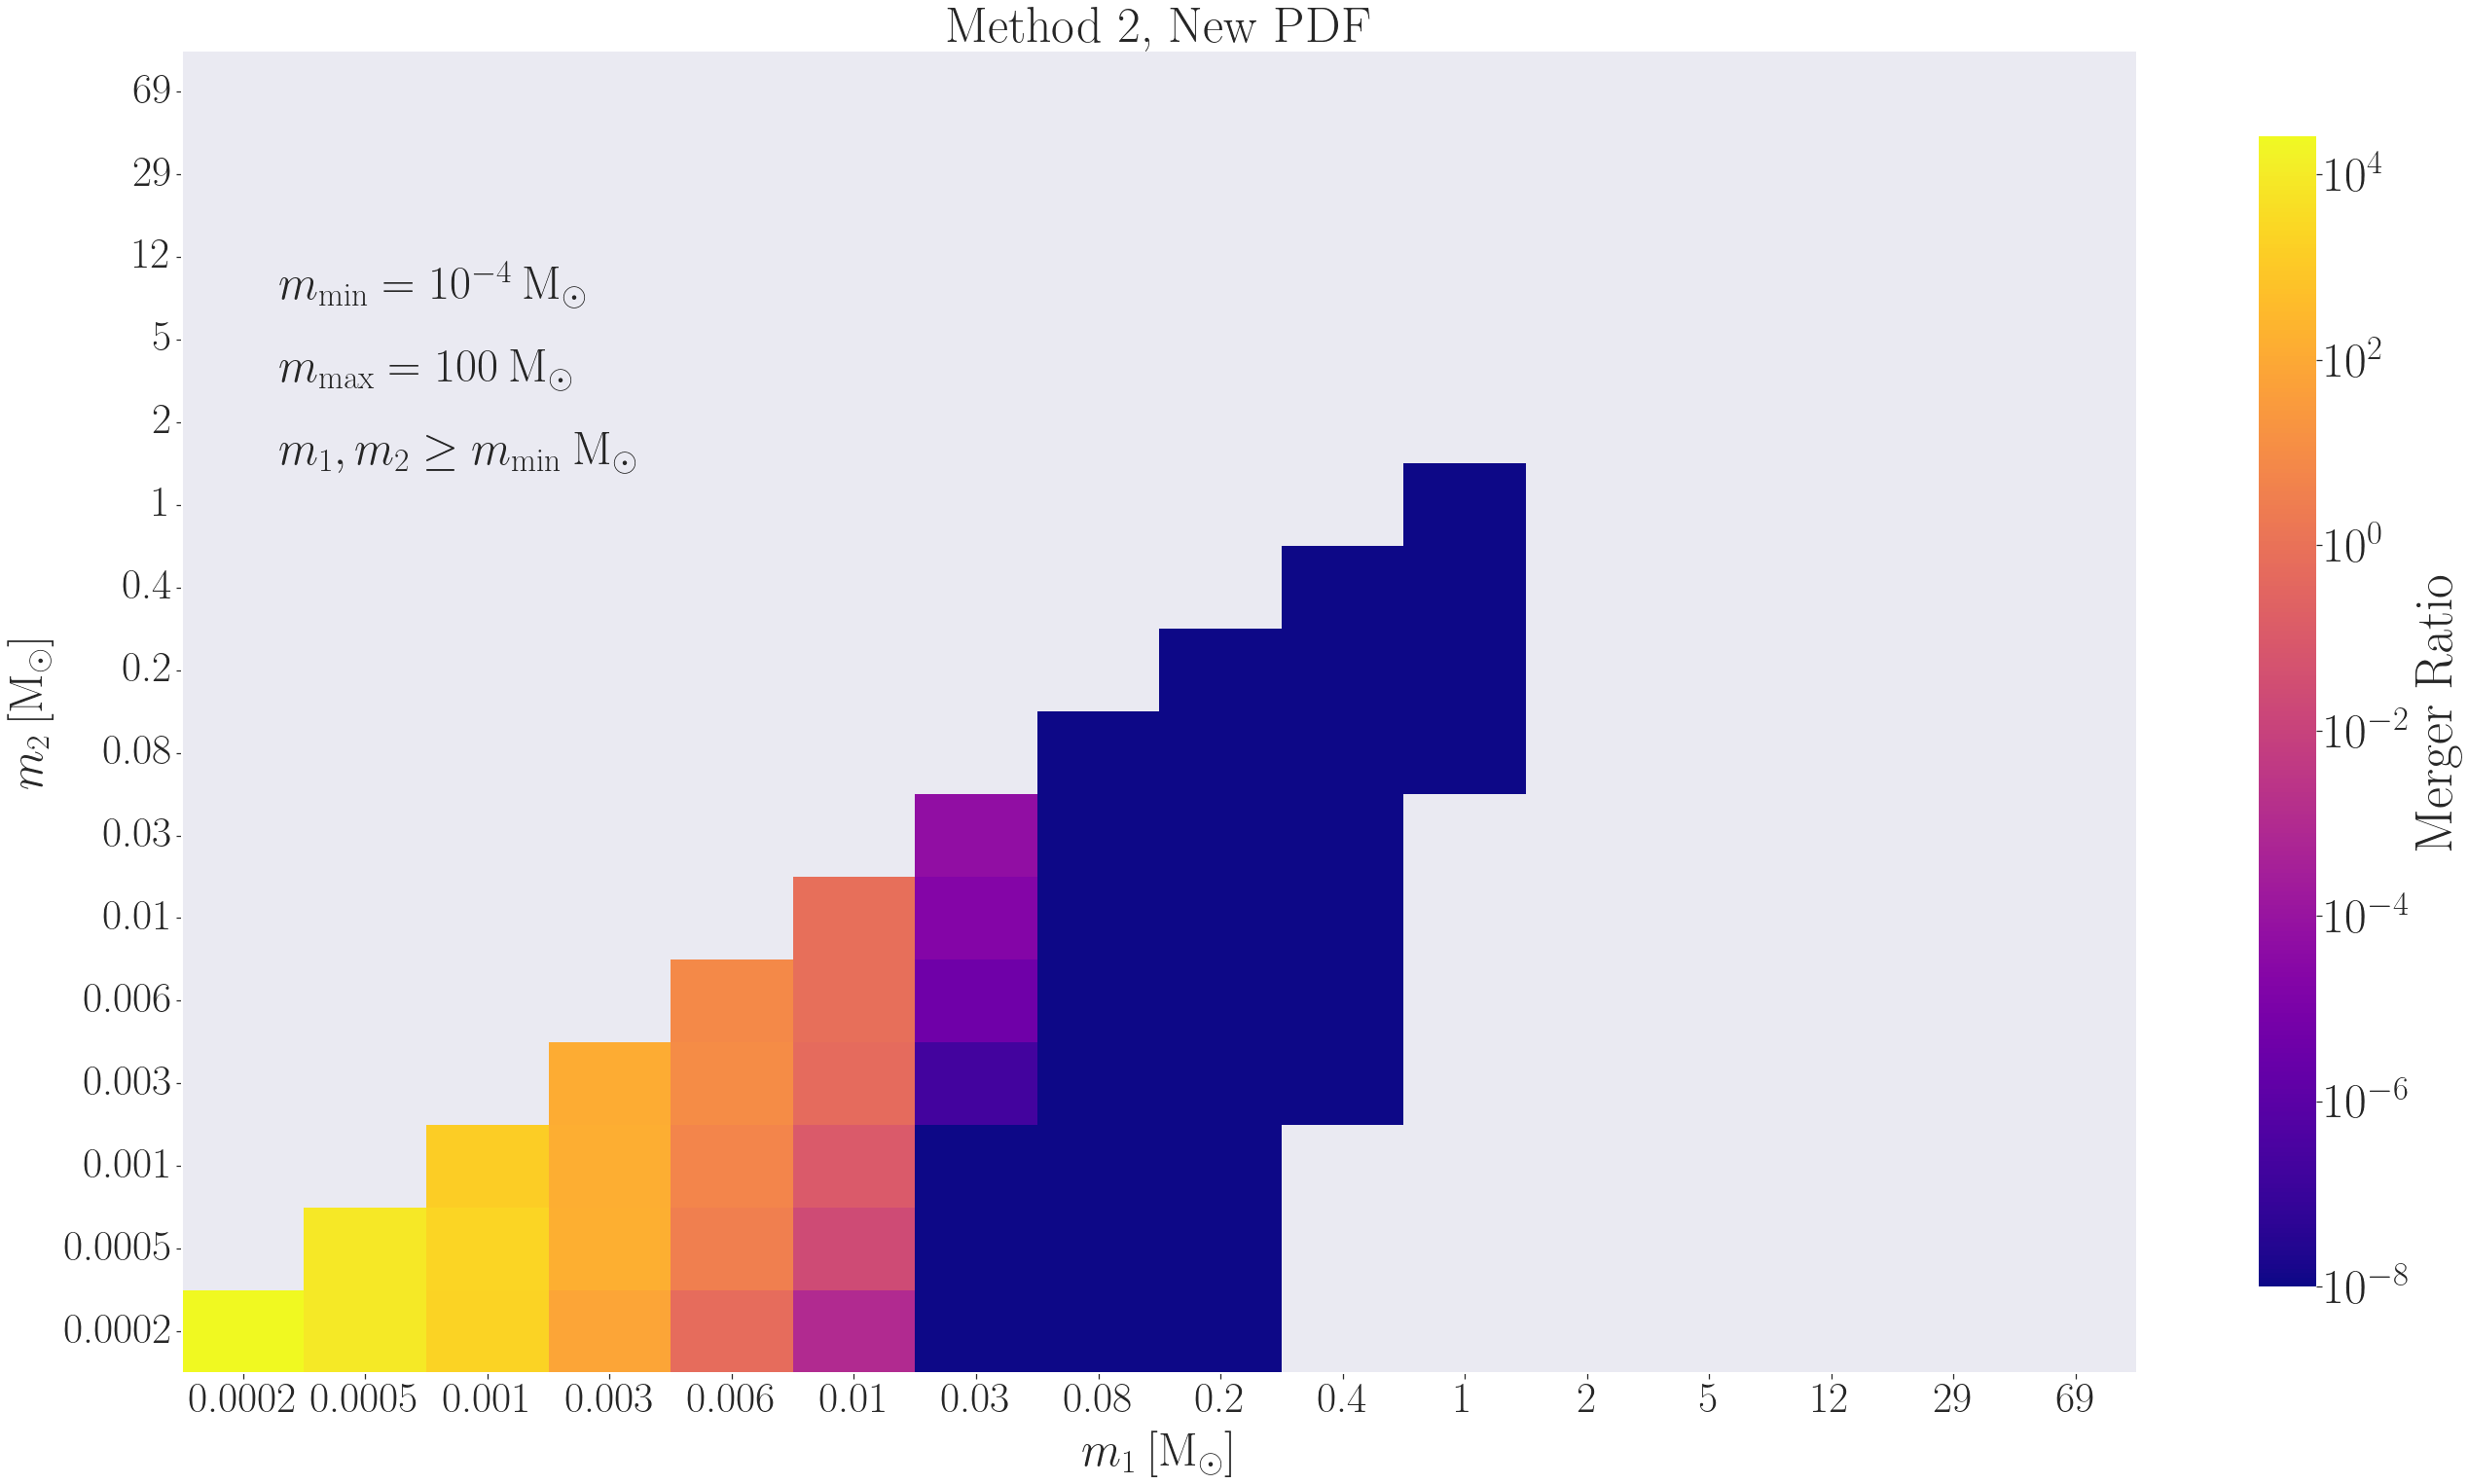

In [53]:
# Ratio of merger rate for binaries with and without DM halos for
# PDF of the paper https://arxiv.org/abs/2207.07576  in 
#  mass range (1e-4 - 100) M_sun.



Merger_new_PDF_nohalo = np.load('Merger_new_PDF_nohalo.npy')
Merger_new_PDF_halo_method_2 = np.load('Merger_new_PDF_halo_method_2.npy')

Merger_new_PDF_ratio_1 = np.divide(Merger_new_PDF_halo_method_2, Merger_new_PDF_nohalo)


mask = np.tril(np.ones((16, 16)), k = -1)  #created an array of shape Merger_12 with all the elements in it being 0.
fig,ax = plt.subplots(figsize=(45, 25))  


sns.set(font_scale = 4.5)
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['font.family'] = 'serif'


vmin = 1e-8
vmax = np.max(Merger_new_PDF_ratio_1)
norm = LogNorm(vmin, vmax)



ax = sns.heatmap(Merger_new_PDF_ratio_1, mask = mask,  cmap = 'plasma', cbar = True, norm = norm,
                 cbar_kws = {"shrink": 0.87, 'label': 'Merger Ratio'},
                 fmt = '0.8f')



ax.set_xticklabels(m_1_list, fontsize = 200)
ax.set_yticklabels(m_2_list,rotation = 360, fontsize = 200)
ax.tick_params(left=True, bottom=True)



ax.text(0.8, 13, "$m_\mathrm{{min}} = 10^{-4} \: \mathrm{M_{\odot}}$", size = 48)
ax.text(0.8, 12, "$m_\mathrm{{max}} = 100 \: \mathrm{M_{\odot}}$", size = 48)
ax.text(0.8, 11, "$m_{1}, m_{2} \geq m_\mathrm{min} \: \mathrm{M_{\odot}}$", size = 48)



# Drawing the frame
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(2)


ax.invert_yaxis()
plt.xticks(fontsize = 44)
plt.yticks(fontsize = 44)
plt.xlabel('$m_{1}\:[\mathrm{M_{\odot}}]$', fontsize = 48, labelpad = 11)   # m_j = m_2
plt.ylabel('$m_{2}\: [\mathrm{M_{\odot}}]$', fontsize = 48, labelpad = 11)  # m_i = m_1  and m_2< equal to m_1.
plt.title('Method 2, New PDF', fontsize = 52, pad = 9)
plt.savefig('1rnewPDF.pdf', bbox_inches = 'tight')
plt.show()     